In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict


/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0 load model

In [2]:
## CIFAR-100
# MODEL_FOLDER = 'models_poe'  # alpha=0, sigmoid T schedule from 2 to 16
# LIKELIHOOD = 'OVR'
# EPOCH = 299

MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

# MODEL_FOLDER = 'models_poe_alpha_0'  # alpha=0, constant T kept at 1, wandb run id 15
# LIKELIHOOD = 'OVR'
# EPOCH = 299

# MODEL_FOLDER = 'models_hybrid_softmax_1'  # wandb run id 60
# LIKELIHOOD = 'softmax'
# EPOCH = 299

# MODEL_FOLDER = 'models_poe_alpha_001'  # wandb run id 57
# LIKELIHOOD = 'softmax'
# EPOCH = 299

# MODEL_FOLDER = 'models_cascade_softmax'  # wandb run id 62
# LIKELIHOOD = 'softmax'
# EPOCH = 299

# MODEL_FOLDER = 'models_cascade_softmax_depth_weights'  # wandb run id 64
# LIKELIHOOD = 'softmax'
# EPOCH = 299

# MODEL_FOLDER = 'models_hybrid_softmax_10'  # wandb run id 61
# LIKELIHOOD = 'softmax'
# EPOCH = 299


# MODEL_FOLDER = 'models_cascade_hybrid_softmax_depth_weights'  # wandb run id 66
# LIKELIHOOD = 'softmax'
# EPOCH = 299


# MODEL_FOLDER = 'models_poe_alpha_001'  # wandb run id 57
# LIKELIHOOD = 'OVR'
# EPOCH = 299

In [3]:
# ## CIFAR-10

# MODEL_FOLDER = 'cifar10/models'
# LIKELIHOOD = 'softmax'
# EPOCH = "049"

In [4]:
logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)
# logits, targets, ARGS = get_logits_targets('cifar10', MODEL_FOLDER, LIKELIHOOD, EPOCH)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

### unit-testing

In [5]:
if ARGS.data == 'cifar100':
    L = len(logits)
    a = torch.softmax(logits, dim=2)
    a_cumsum = a.cumsum(dim=0)
    a_cumsum_mean = a.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]

    n = 7390
    c = 77

    tmp = 0
    for i in range(7):
        tmp += a[i, n, c]
        assert np.isclose(a_cumsum[i, n, c], tmp)
        assert np.isclose(a_cumsum_mean[i, n, c], (tmp / (i + 1)))
        # print(tmp, tmp / (i + 1))

## 1 Softmax

### 1.1 anytime-prediction: performance

In [6]:
L = len(logits)

In [7]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [8]:
acc

[tensor(0.6513),
 tensor(0.6811),
 tensor(0.7065),
 tensor(0.7223),
 tensor(0.7264),
 tensor(0.7286),
 tensor(0.7286)]

In [9]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [10]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

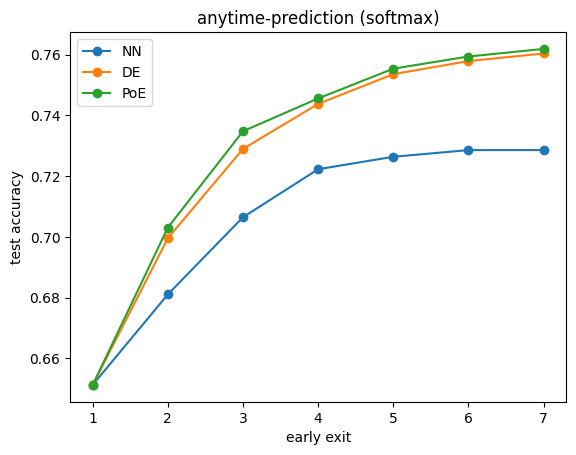

In [11]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc, label='NN', marker='o')
plt.plot(early_exits, acc_de, label='DE', marker='o')
plt.plot(early_exits, acc_poe, label='PoE', marker='o')
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

### 1.2 anytime-prediction: modal probability 

#### 1.2.1 plots

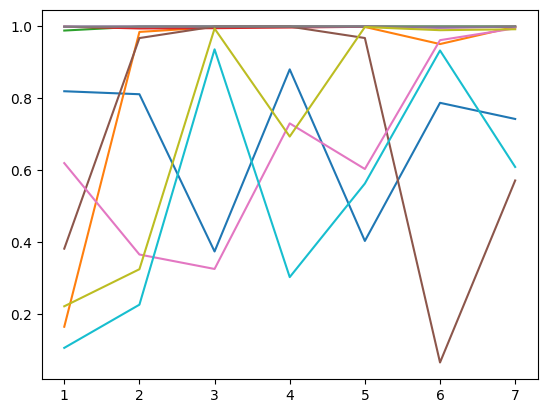

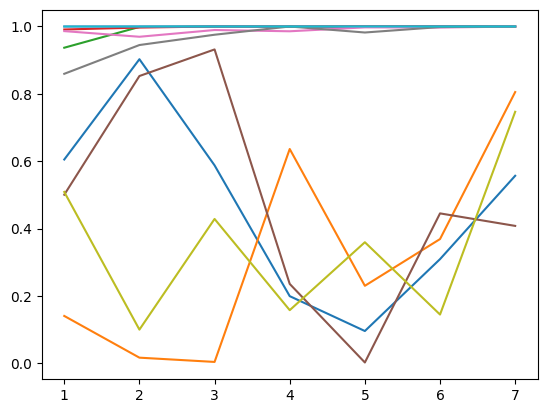

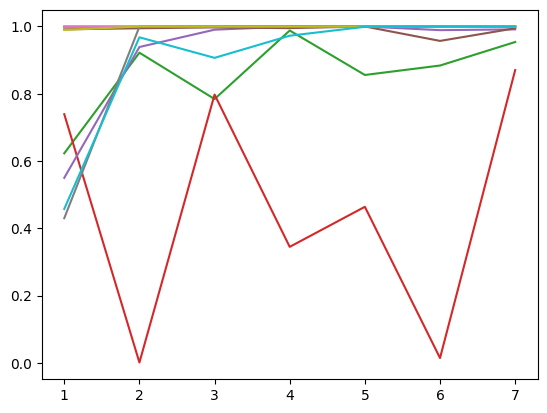

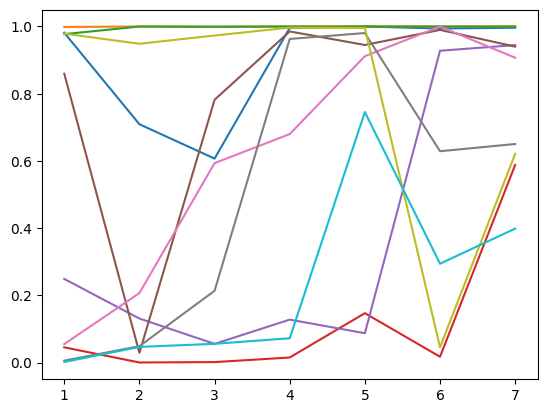

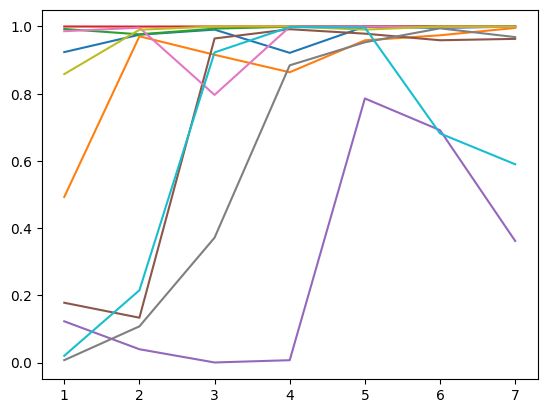

In [12]:
_preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### 1.2.2 sanity check that MSDNet displays conditional non-monotonicity

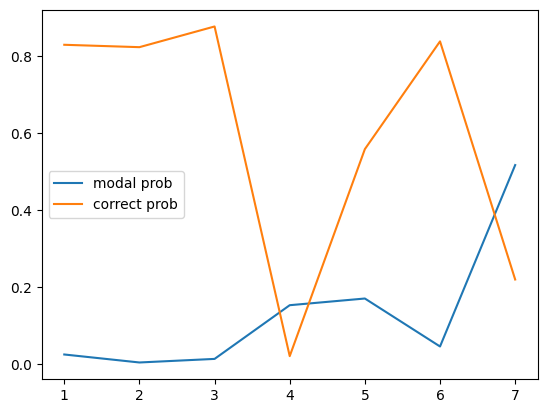

In [13]:
i = 1000
plt.plot(np.arange(1, 8, 1), probs[:, i, preds[L - 1][i]].numpy(), label='modal prob')
plt.plot(np.arange(1, 8, 1), probs[:, i, targets[i]].numpy(), label='correct prob')
plt.legend()
plt.show()

In [14]:
_test_arr = []
for i in range(10000):
    _test_arr.append(probs[:, i, preds[L - 1][i]].numpy())
_test_arr = np.array(_test_arr)

In [15]:
max_decrease = - np.min(np.diff(_test_arr, axis=1), axis=1)

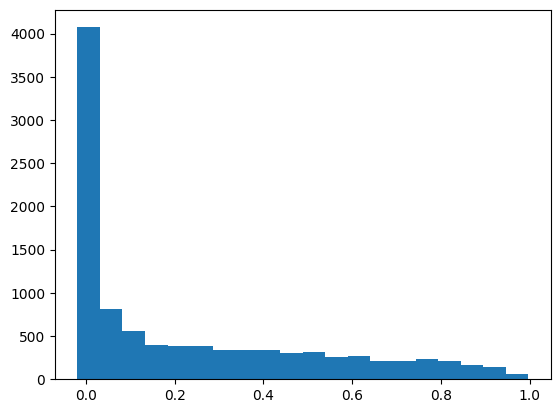

In [16]:
plt.hist(max_decrease, bins=20);

In [17]:
THRES = 0.5
(max_decrease > THRES).sum() / len(max_decrease)

0.1983

#### 1.2.2 nr. of test examples with decreasing modal probabilities throughout sequential evaluation

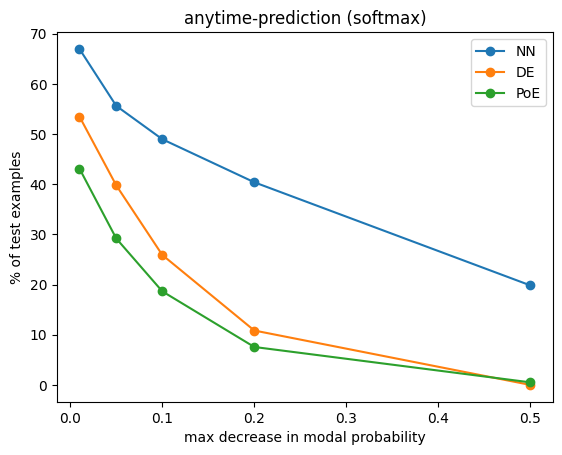

In [18]:
for _preds, _poe, label in [(preds, probs, 'NN'), (preds_de, probs_de, 'DE'), (preds_poe, probs_poe, 'PoE')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.xlabel('max decrease in modal probability')
plt.ylabel('% of test examples')
plt.show()

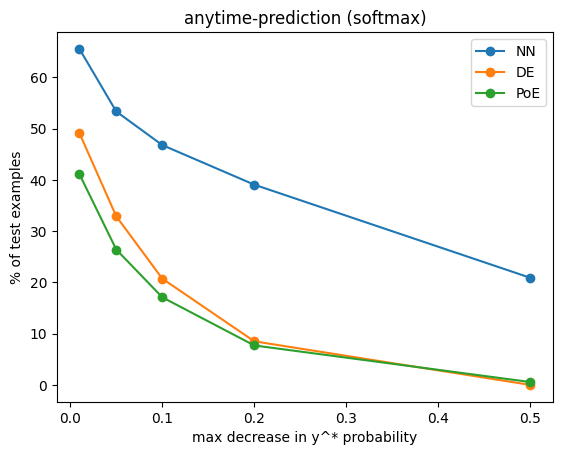

In [19]:
_targets = {l: targets for l in range(L)}
for _preds, _poe, label in [(_targets, probs, 'NN'), (_targets, probs_de, 'DE'), (_targets, probs_poe, 'PoE')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
plt.legend()
plt.title('anytime-prediction (softmax)')
plt.xlabel('max decrease in y^* probability')
plt.ylabel('% of test examples')
plt.show()

#### 1.2.3 MSP throughout sequential evaluation

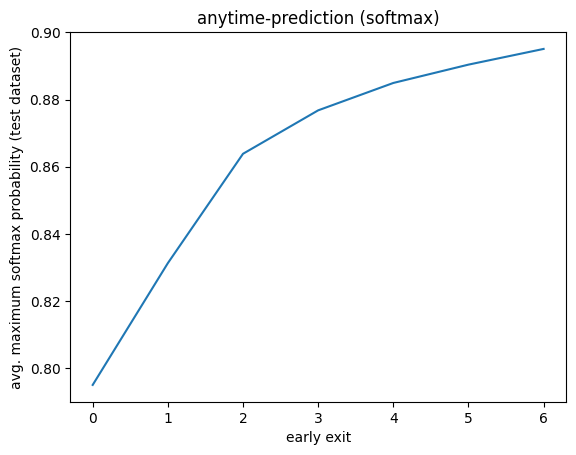

In [20]:
plt.plot(list(range(len(msp))), [msp[j].mean() for j in range(len(msp))])
plt.title('anytime-prediction (softmax)')
plt.xlabel('early exit')
plt.ylabel('avg. maximum softmax probability (test dataset)')
plt.show()

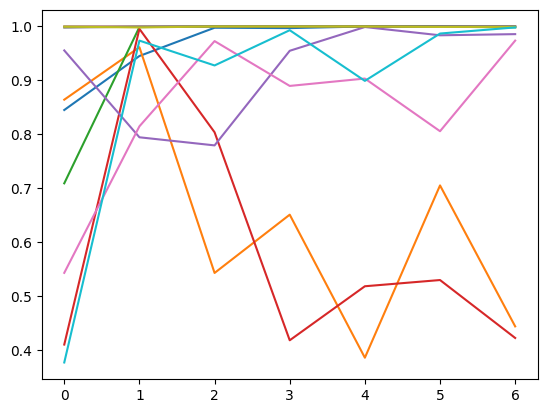

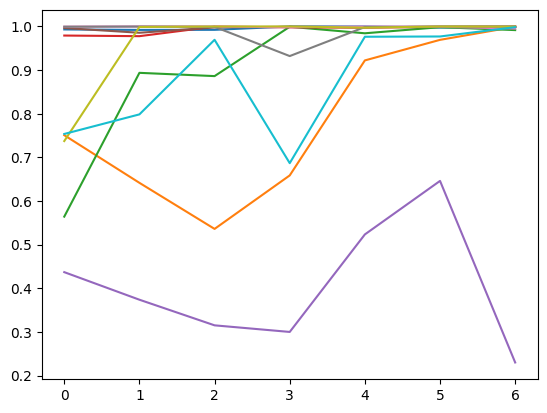

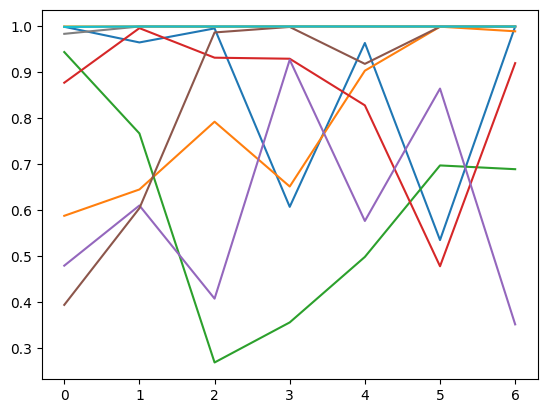

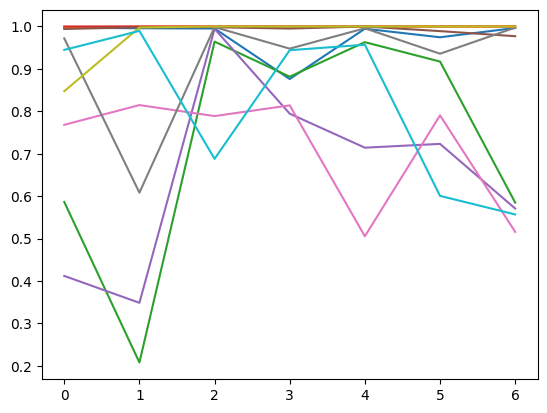

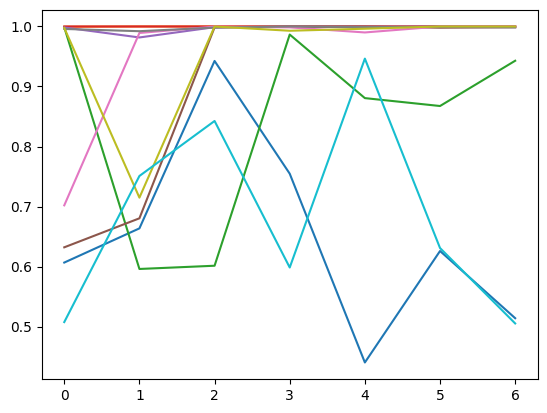

In [21]:
for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        msp_i = [msp[j][i] for j in range(len(msp))]
        plt.plot(list(range(len(msp_i))), msp_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### 1.2.4 rankings plots

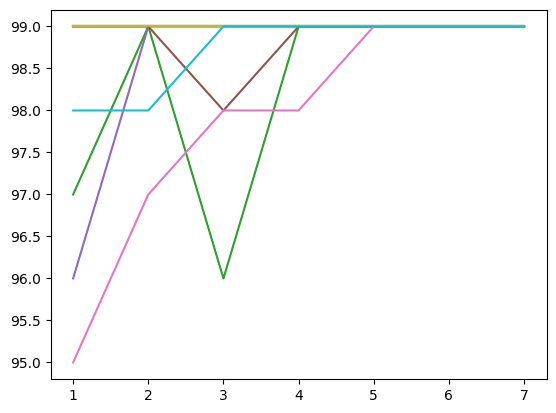

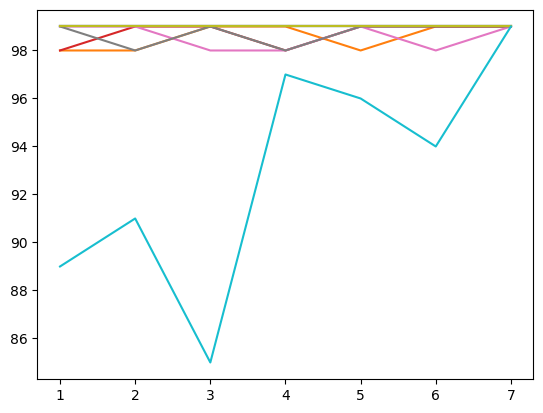

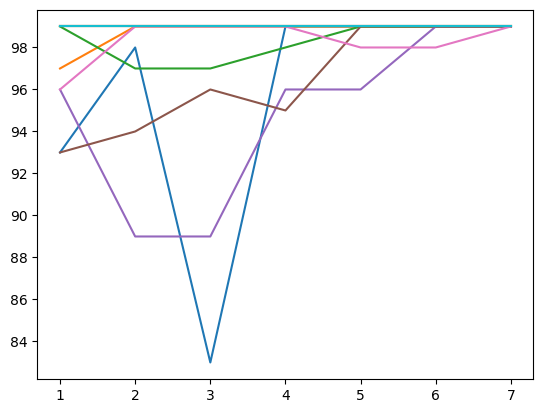

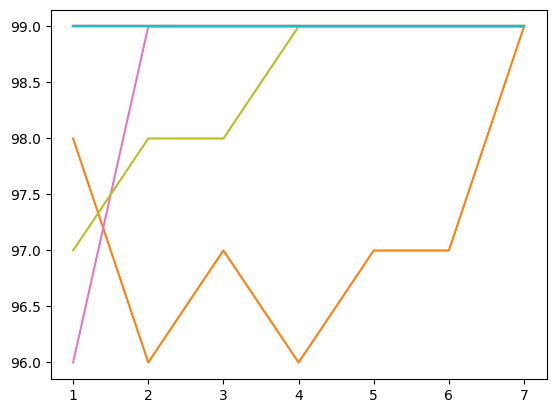

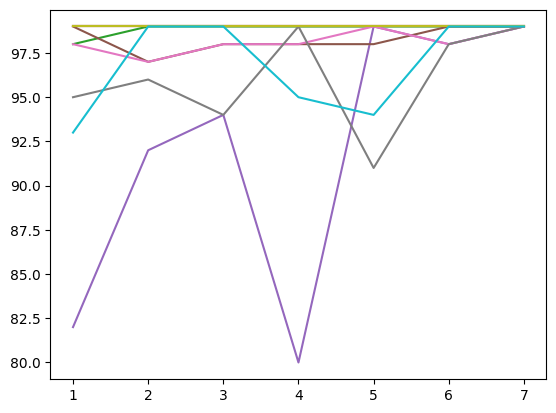

In [22]:
_preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        rankings_i = [np.where(_probs[l, i, :].numpy().argsort() == int(_preds[i]))[0][0] for l in range(L)]
        plt.plot(list(range(1, len(rankings_i) + 1)), rankings_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### 1.2.5. plots for presentation

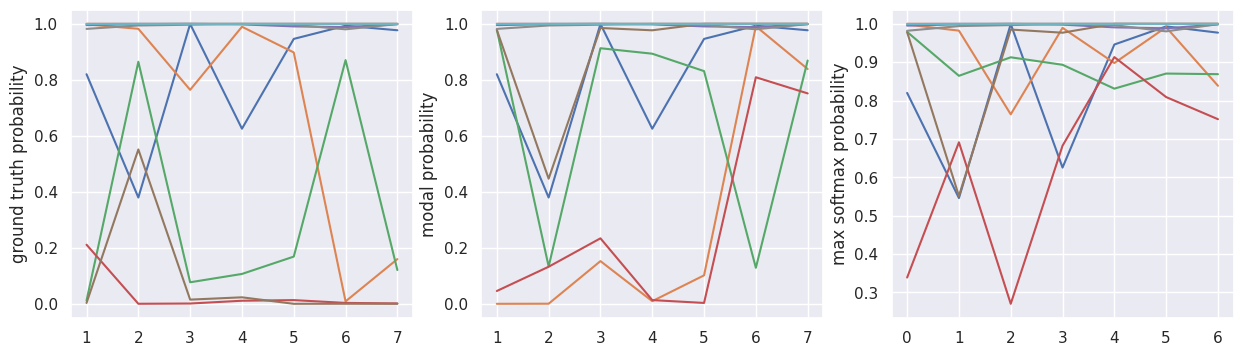

In [23]:
import seaborn as sns
sns.set_theme()
_preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
samples = random.sample(range(10000), 10)
for i in samples:
    probs_i = _probs[:, i, _preds[i]].cpu()
    ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    probs_grount_truth_i = _probs[:, i, targets[i]].cpu()
    ax[0].plot(list(range(1, len(probs_grount_truth_i) + 1)), probs_grount_truth_i, label=f'{i}');
    msp_i = [msp[j][i] for j in range(len(msp))]
    ax[2].plot(list(range(len(msp_i))), msp_i, label=f'{i}');

# plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
ax[0].set_ylabel('ground truth probability')
ax[1].set_ylabel('modal probability')
ax[2].set_ylabel('max softmax probability')
# plt.xlabel('early exit')
plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/msdnet_conditional_non_monotonicify.pdf')
plt.show()

## 2 OVR

### 2.1 anytime-prediction: performance

In [24]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]
ids_ood_ovr = get_ood_ovr(probs_ovr)
nr_ood_ovr = {l: len(l_dict) for l, l_dict in ids_ood_ovr.items()}

_ids = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_ovr.items()}
acc_ovr_excluding_ood = [(targets[_ids[i]] == preds_ovr[i][_ids[i]]).sum() / len(targets[_ids[i]]) for i in range(L)]

In [25]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]
ids_ood_poe_ovr = get_ood_ovr(probs_poe_ovr)
nr_ood_poe_ovr = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr.items()}

_ids = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_poe_ovr.items()}
acc_poe_ovr_excluding_ood = [(targets[_ids[i]] == preds_poe_ovr[i][_ids[i]]).sum() / len(targets[_ids[i]]) for i in range(L)]

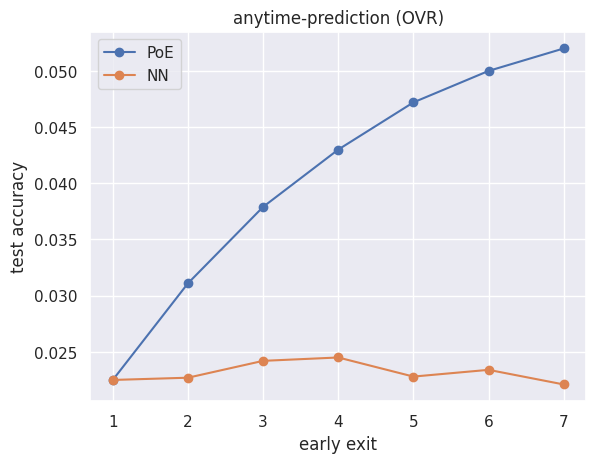

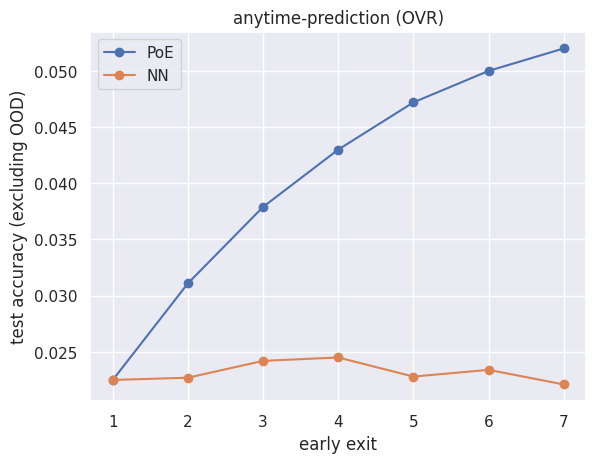

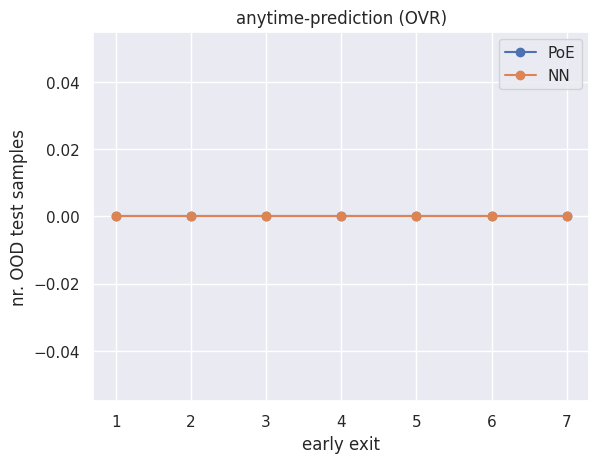

In [26]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_poe_ovr, marker='o', label='PoE')
plt.plot(early_exits, acc_ovr, marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, acc_poe_ovr_excluding_ood, marker='o', label='PoE')
plt.plot(early_exits, acc_ovr_excluding_ood, marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy (excluding OOD)')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, nr_ood_poe_ovr.values(), marker='o', label='PoE')
plt.plot(early_exits, nr_ood_ovr.values(), marker='o', label='NN')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('nr. OOD test samples')
plt.xlabel('early exit')
plt.show()

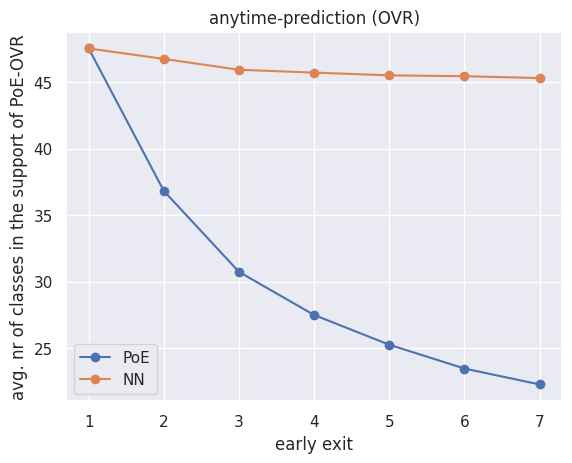

In [27]:
plt.plot(list(range(1, L + 1)), [np.mean((probs_poe_ovr[l] > 0).sum(axis=1).numpy()) for l in range(L)], marker='o', label='PoE')
plt.plot(list(range(1, L + 1)), [np.mean((probs_ovr[l] > 0).sum(axis=1).numpy()) for l in range(L)], marker='o', label='NN')
plt.title('anytime-prediction (OVR)')
plt.ylabel('avg. nr of classes in the support of PoE-OVR')
plt.xlabel('early exit')
plt.legend()
plt.show()

In [28]:
modal_probs_ovr = modal_probs_decreasing(preds_poe_ovr, probs_poe_ovr, L)
for thres, val in modal_probs_ovr.items():
    print(thres, val)

0.01 0.0
0.05 0.0
0.1 0.0
0.2 0.0
0.5 0.0


### 2.2 fallback on (product of sigmoid of) logits in case of zero prob

In [29]:
preds_ovr_fallback_ood = f_preds_ovr_fallback_ood(logits=logits, probs=probs_ovr)
probs_ovr_fallback_ood = f_probs_ovr_fallback_ood(logits=logits, probs=probs_ovr)
acc_ovr_fallback_ood = [(targets == preds_ovr_fallback_ood[i]).sum() / len(targets) for i in range(L)]

preds_poe_ovr_fallback_ood = f_preds_ovr_fallback_ood(logits=logits, probs=probs_poe_ovr, prod=True)
probs_poe_ovr_fallback_ood = f_probs_ovr_fallback_ood(logits=logits, probs=probs_poe_ovr, prod=True)
acc_poe_ovr_fallback_ood = [(targets == preds_poe_ovr_fallback_ood[i]).sum() / len(targets) for i in range(L)]

In [30]:
# unit tests for f_probs_ovr_fallback_ood
_preds_ovr_fallback_ood = {i: torch.argmax(probs_ovr_fallback_ood, dim=2)[i, :] for i in range(L)}
_preds_poe_ovr_fallback_ood = {i: torch.argmax(probs_poe_ovr_fallback_ood, dim=2)[i, :] for i in range(L)}
for j in range(L):
    torch.equal(preds_ovr_fallback_ood[j], _preds_ovr_fallback_ood[j])
    torch.equal(preds_poe_ovr_fallback_ood[j], _preds_poe_ovr_fallback_ood[j])

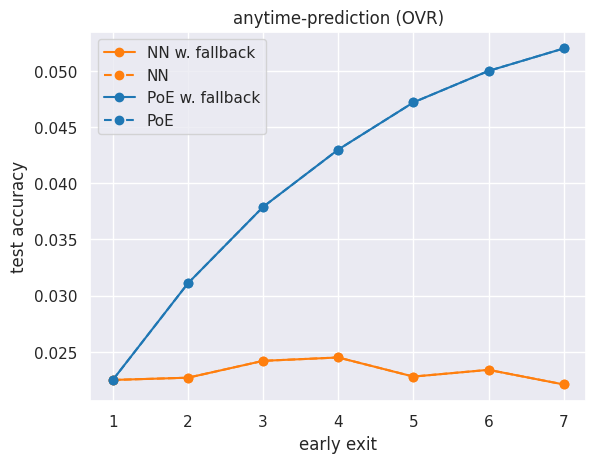

In [31]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_ovr_fallback_ood, marker='o', label='NN w. fallback', color='#ff7f0e')
plt.plot(early_exits, acc_ovr, marker='o', label='NN', color='#ff7f0e', linestyle='--')
plt.plot(early_exits, acc_poe_ovr_fallback_ood, marker='o', label='PoE w. fallback', c='#1f77b4')
plt.plot(early_exits, acc_poe_ovr, marker='o', label='PoE', c='#1f77b4', linestyle='--')
plt.legend()
plt.title('anytime-prediction (OVR)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

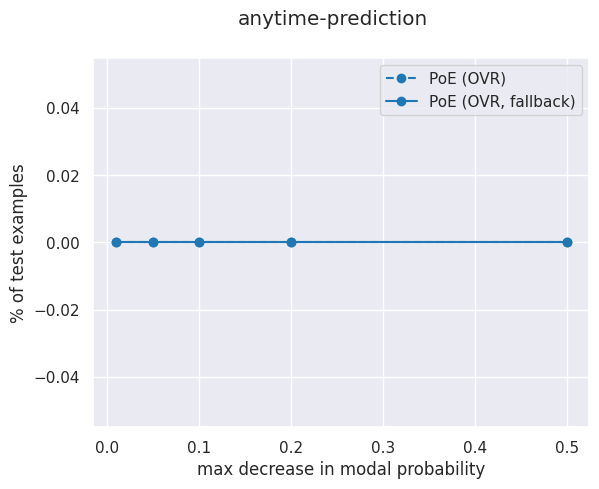

In [32]:
for _preds, _poe, label, linestyle in [(preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)', '--'),
                            (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fallback)', '-')]:
    modal_probs = modal_probs_decreasing(_preds, _poe, L)
    plt.plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label, c='#1f77b4', linestyle=linestyle)
plt.legend()
# ax[1].set_title('anytime-prediction')
plt.xlabel('max decrease in modal probability')
plt.ylabel('% of test examples')
plt.suptitle('anytime-prediction')
plt.show()

In [33]:
modal_probs = modal_probs_decreasing(preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, L, verbose=True)

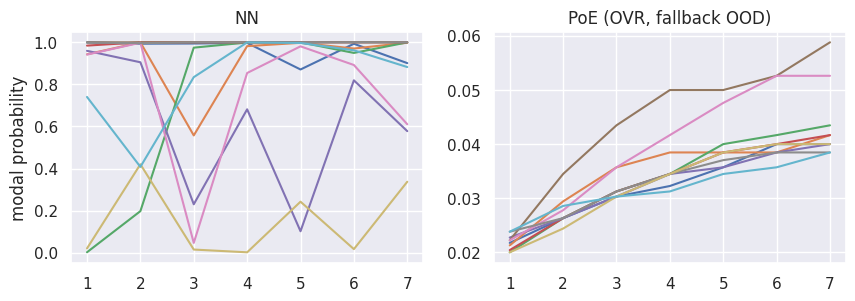

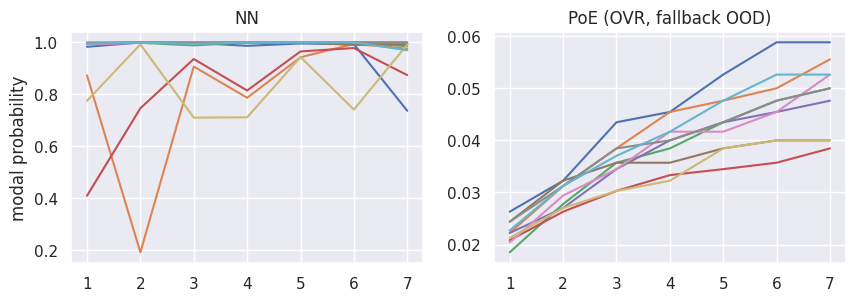

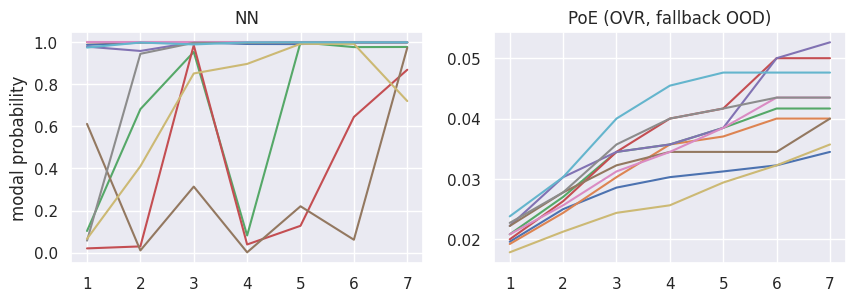

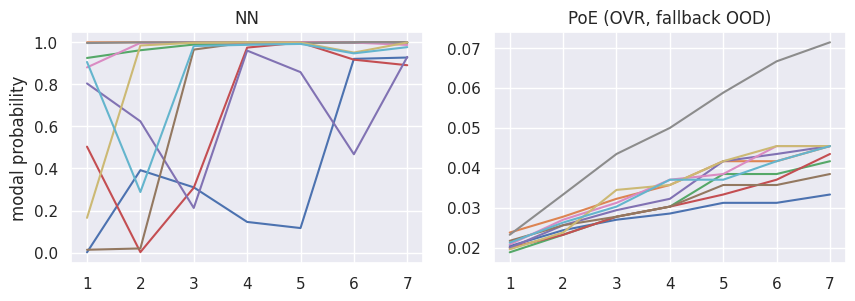

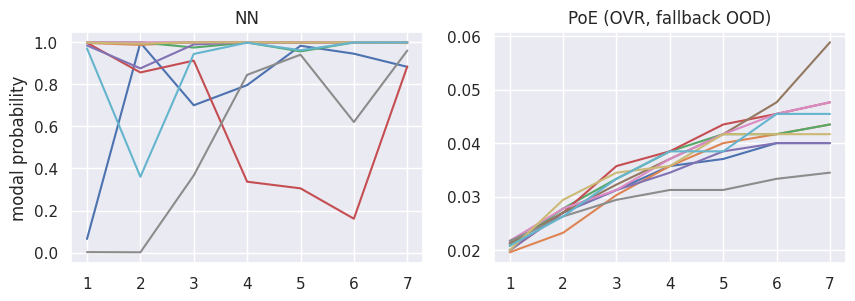

In [34]:
_preds = preds_poe_ovr_fallback_ood[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_fallback_ood

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, fallback OOD)')
    ax[0].set_ylabel('modal probability')
    plt.show()

### 2.3 break-ties (in case of distribution being not sharp enough/having too large support)

In [35]:
# probs_poe_ovr_break_ties = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr)
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

ids_ood_poe_ovr_break_ties = get_ood_ovr(probs_poe_ovr_break_ties)
nr_ood_poe_ovr_break_ties = {l: len(l_dict) for l, l_dict in ids_ood_poe_ovr_break_ties.items()}

_ids_bt = {l: [i for i in range(10000) if i not in l_ids] for l, l_ids in ids_ood_poe_ovr_break_ties.items()}
acc_poe_ovr_excluding_ood_break_ties = [(targets[_ids_bt[i]] == preds_poe_ovr_break_ties[i][_ids_bt[i]]).sum() / len(targets[_ids_bt[i]]) for i in range(L)]

In [36]:
msp_poe_ovr_break_ties = {i: torch.max(probs_poe_ovr_break_ties, dim=2).values[i, :] for i in range(L)}

In [37]:
acc_poe_ovr_break_ties

[tensor(0.6513),
 tensor(0.7032),
 tensor(0.7311),
 tensor(0.7435),
 tensor(0.7546),
 tensor(0.7583),
 tensor(0.7600)]

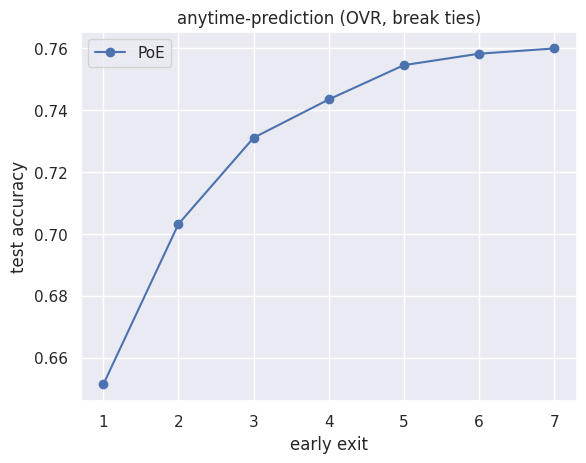

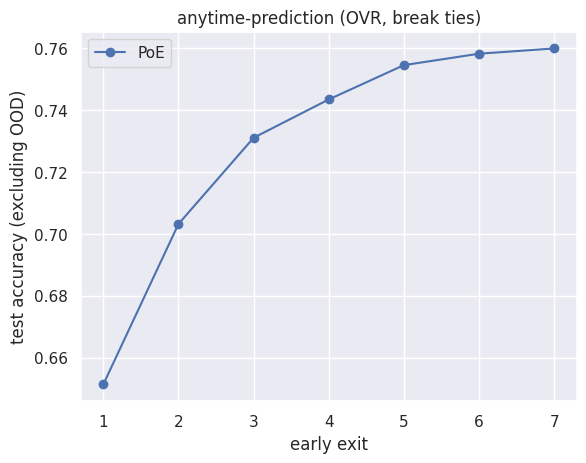

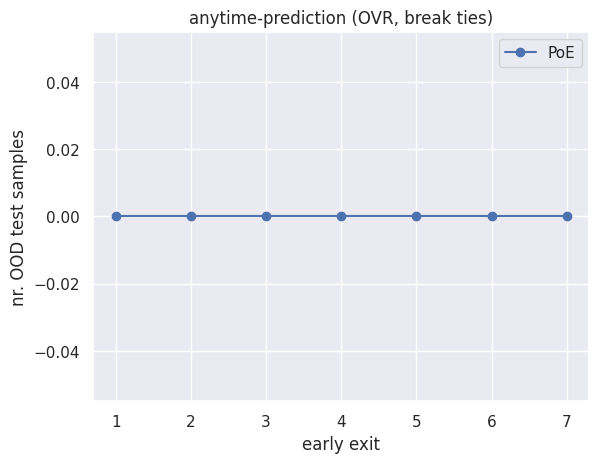

In [38]:
early_exits = [i + 1 for i in range(len(acc))]
plt.plot(early_exits, acc_poe_ovr_break_ties, marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('test accuracy')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, acc_poe_ovr_excluding_ood_break_ties, marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('test accuracy (excluding OOD)')
plt.xlabel('early exit')
plt.show()

plt.plot(early_exits, nr_ood_poe_ovr_break_ties.values(), marker='o', label='PoE')
plt.legend()
plt.title('anytime-prediction (OVR, break ties)')
plt.ylabel('nr. OOD test samples')
plt.xlabel('early exit')
plt.show()

In [39]:
modal_probs_ovr_break_ties = modal_probs_decreasing(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, L)
for thres, val in modal_probs_ovr_break_ties.items():
    print(thres, val)

0.01 3.1300000000000003
0.05 0.5499999999999999
0.1 0.09
0.2 0.0
0.5 0.0


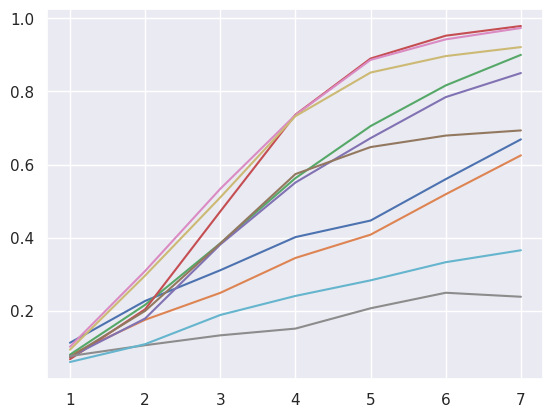

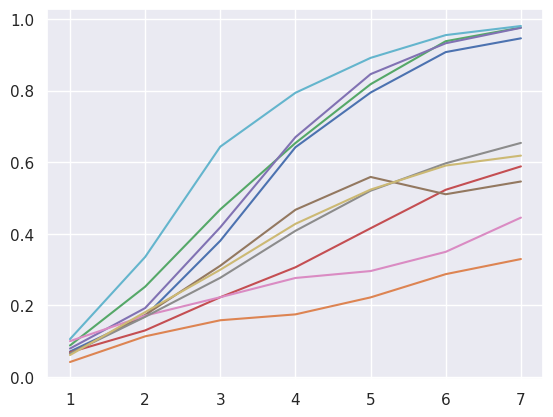

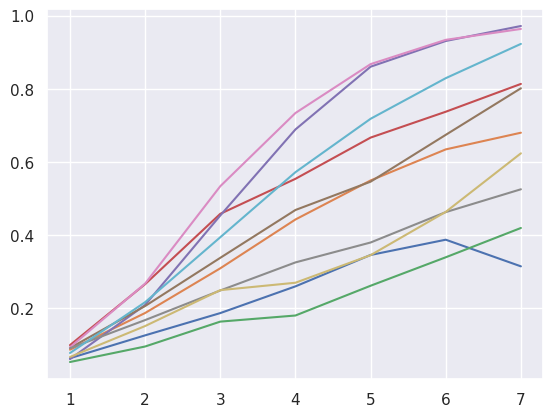

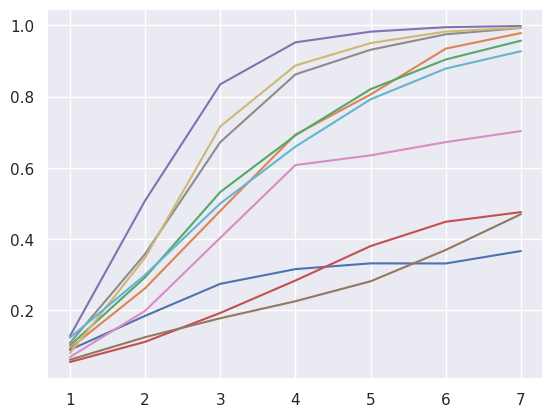

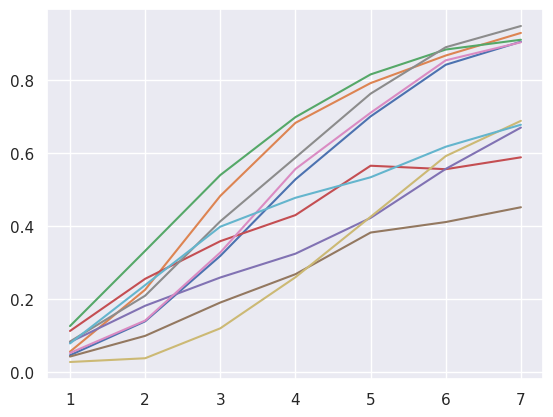

In [40]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

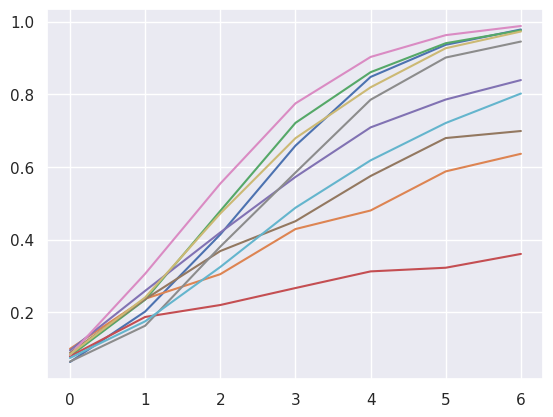

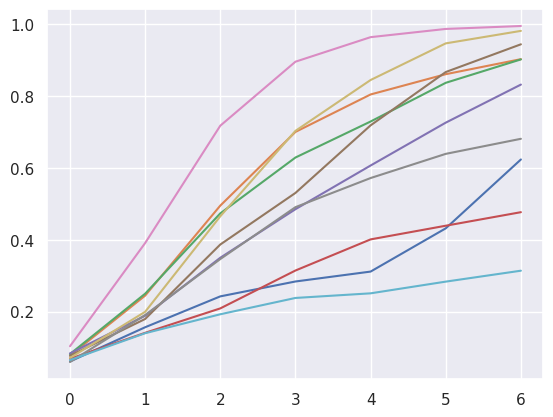

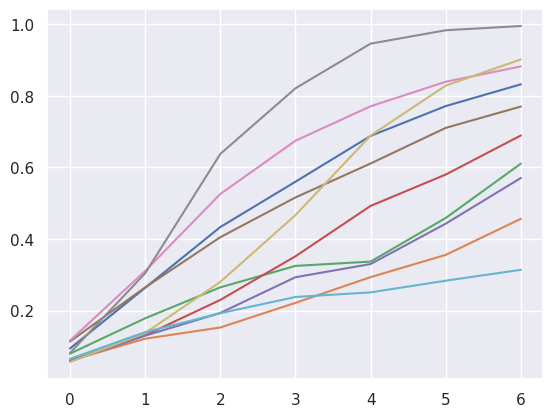

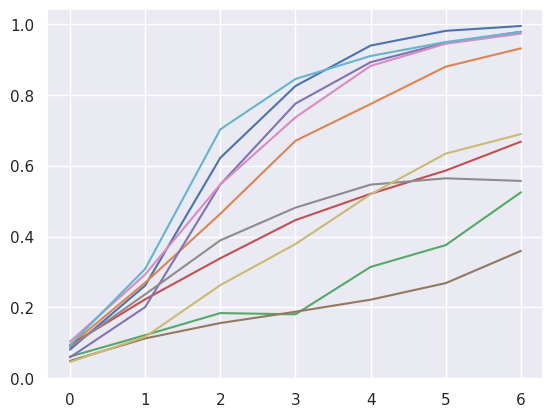

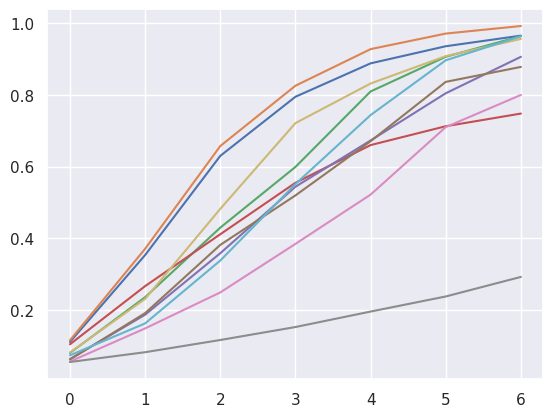

In [41]:
for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        msp_i = [msp_poe_ovr_break_ties[j][i] for j in range(len(msp))]
        plt.plot(list(range(len(msp_i))), msp_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

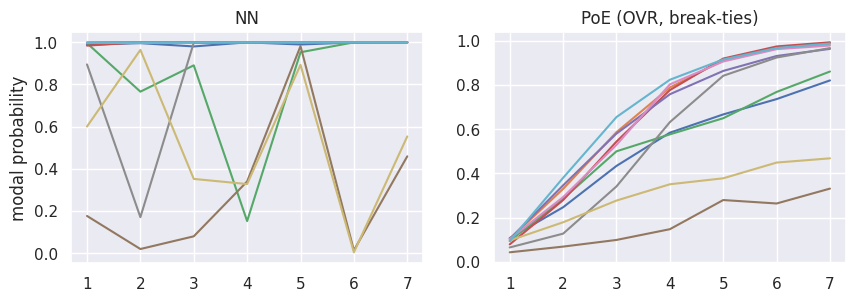

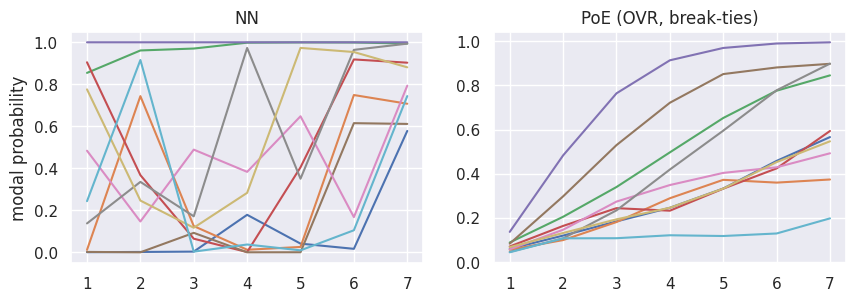

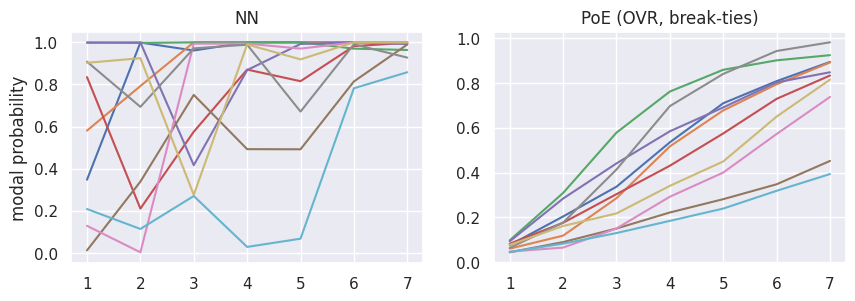

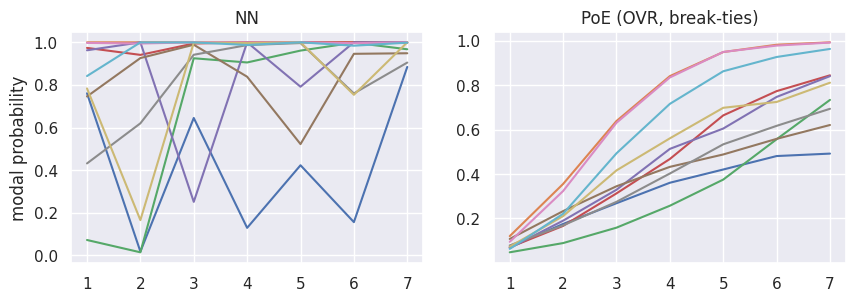

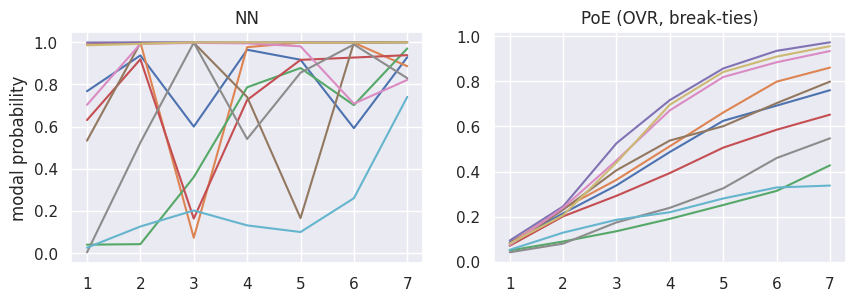

In [42]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, break-ties)')
    ax[0].set_ylabel('modal probability')
    plt.show()

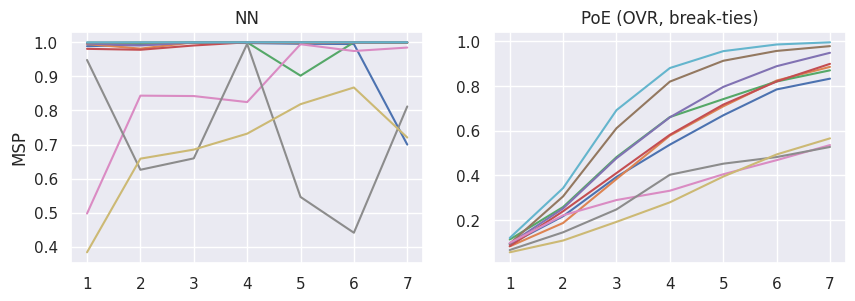

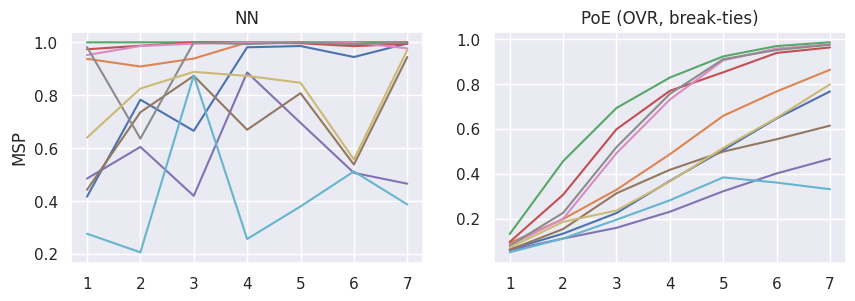

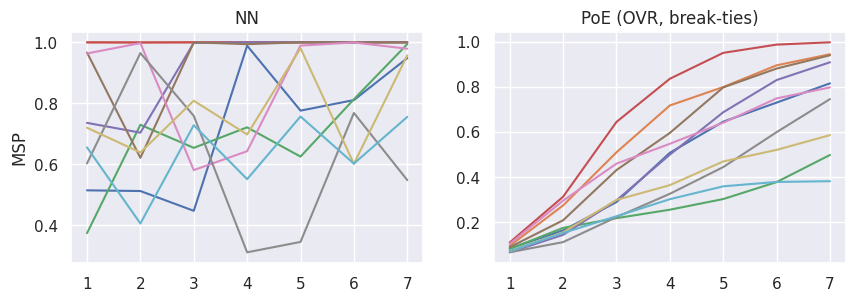

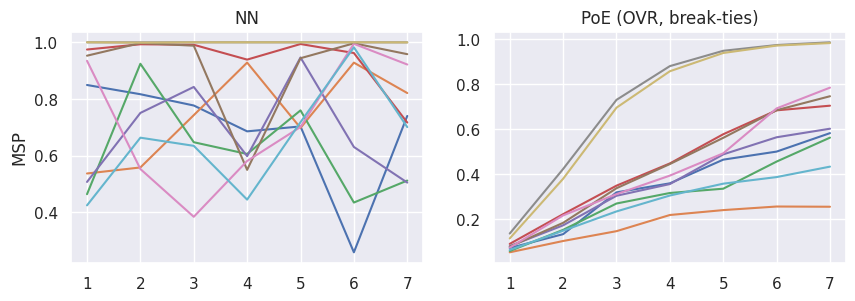

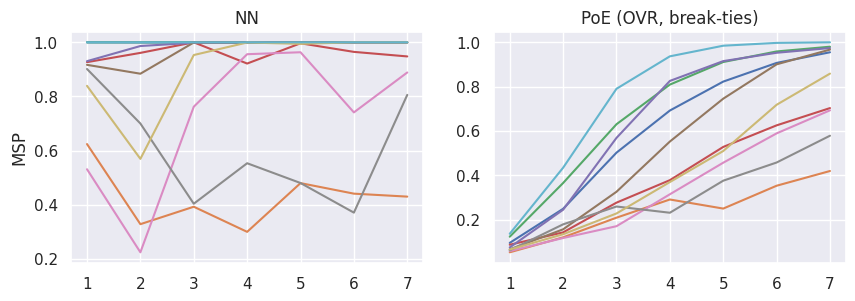

In [43]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        msp_i = [msp_poe_ovr_break_ties[j][i] for j in range(L)]
        msp_i_baseline = [msp[j][i] for j in range(L)]
        ax[0].plot(list(range(1, len(msp_i_baseline) + 1)), msp_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(msp_i) + 1)), msp_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, break-ties)')
    ax[0].set_ylabel('MSP')
    plt.show()



### 2.4 break-ties and tempering

TODO: understand why temperature scaling with T > 1 leads to drop in accuracy for OVR, break-ties

In [44]:
# probs_poe_ovr_break_ties_tempered = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr, T=0.01)
# preds_poe_ovr_break_ties_tempered = {i: torch.argmax(probs_poe_ovr_break_ties_tempered, dim=2)[i, :] for i in range(L)}
# acc_poe_ovr_break_ties_tempered = [(targets == preds_poe_ovr_break_ties_tempered[i]).sum() / len(targets) for i in range(L)]

In [45]:
# probs_poe_ovr_break_ties_tempered[6, 0, :]

In [46]:
# acc_poe_ovr_break_ties_tempered

In [47]:
# modal_probs_ovr_break_ties_tempered = modal_probs_decreasing(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, L)
# for thres, val in modal_probs_ovr_break_ties_tempered.items():
#     print(thres, val)

### 2.5 break-ties and softmax-tempering

apply softmax with large T to OVR, break-ties probabilities in order to scale them up while preserving the ranking

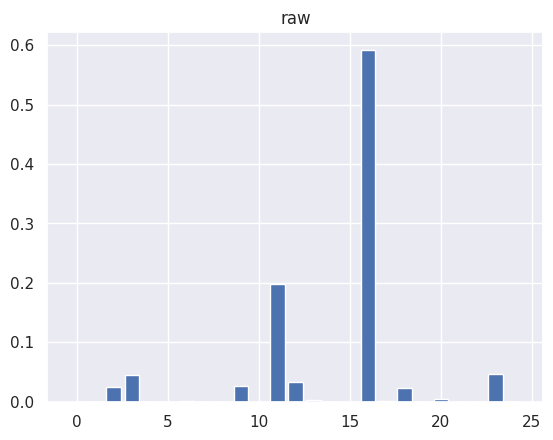

tensor([24,  8, 21,  4,  0, 15,  7,  5, 14, 22, 10,  1, 19,  6, 17, 13, 20, 18,
         2,  9, 12,  3, 23, 11, 16])


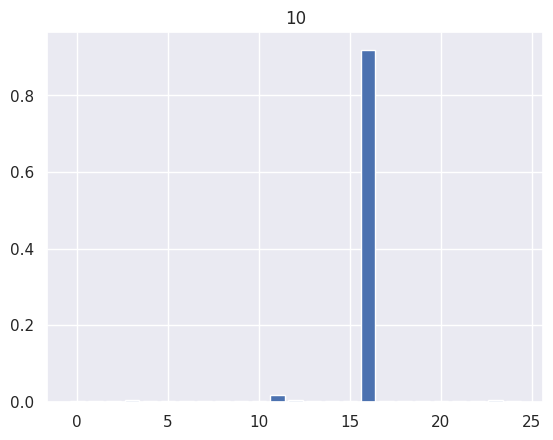

tensor([24,  8, 21,  4,  0, 15,  7,  5, 14, 22, 10,  1, 19,  6, 17, 13, 20, 18,
         2,  9, 12,  3, 23, 11, 16])


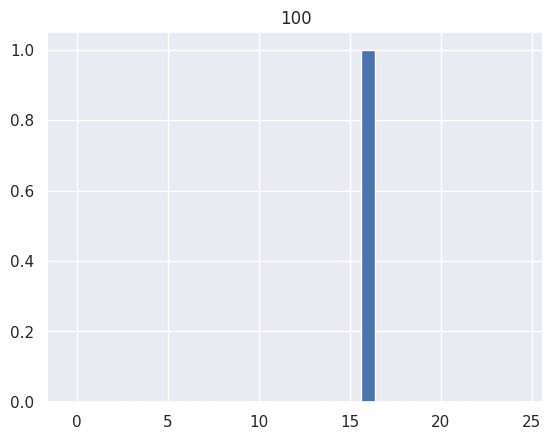

tensor([24,  8, 21,  4,  0, 15,  7,  5, 14, 22, 10,  1, 19,  6, 17, 13, 20, 18,
         2,  9, 12,  3, 23, 11, 16])


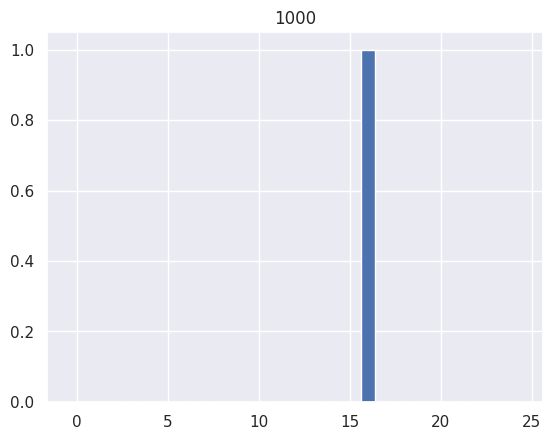

tensor([12, 24, 23, 22, 21, 20, 19, 18, 17, 15, 14, 13,  0, 11, 10,  9,  8,  7,
         6,  5,  4,  3,  2,  1, 16])


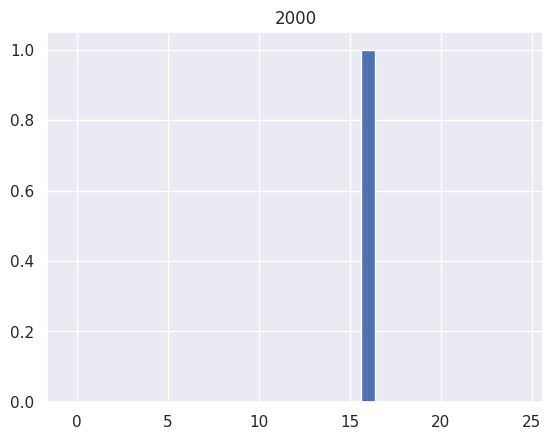

tensor([12, 24, 23, 22, 21, 20, 19, 18, 17, 15, 14, 13,  0, 11, 10,  9,  8,  7,
         6,  5,  4,  3,  2,  1, 16])


In [48]:
example_probs = probs_poe_ovr_break_ties[6, 0, :]
support_mask = (example_probs != 0.)
nr_non_zero = support_mask.sum().numpy()

support = np.arange(0, nr_non_zero, 1)

plt.bar(support, example_probs[support_mask])
plt.title('raw')
plt.show()
print(torch.argsort(example_probs[support_mask]))
for T in [10, 100, 1000, 2000]:
    _tempered_probs = torch.softmax(T * example_probs[support_mask], dim=0)
    plt.bar(support, _tempered_probs)
    plt.title(f'{T}')
    plt.show()
    print(torch.argsort(_tempered_probs))

In [49]:
T = 10000.
probs_poe_ovr_break_ties_tempered_softmax = probs_poe_ovr_break_ties.clone()
for l in range(probs_poe_ovr_break_ties_tempered_softmax.shape[0]):
    for n in range(probs_poe_ovr_break_ties_tempered_softmax.shape[1]):
        _probs_l_n_mask = probs_poe_ovr_break_ties_tempered_softmax[l, n, :] != 0.
        _tempered_probs = torch.softmax(T * probs_poe_ovr_break_ties_tempered_softmax[l, n, :][_probs_l_n_mask], dim=0)
        probs_poe_ovr_break_ties_tempered_softmax[l, n, :][_probs_l_n_mask] = _tempered_probs


preds_poe_ovr_break_ties_tempered_softmax = {i: torch.argmax(probs_poe_ovr_break_ties_tempered_softmax, dim=2)[i, :] for i in range(L)}

In [50]:
for l in range(L):
    print(l, (preds_poe_ovr_break_ties_tempered_softmax[l] == preds_poe_ovr_break_ties[l]).sum())

0 tensor(10000)
1 tensor(10000)
2 tensor(10000)
3 tensor(10000)
4 tensor(10000)
5 tensor(10000)
6 tensor(10000)


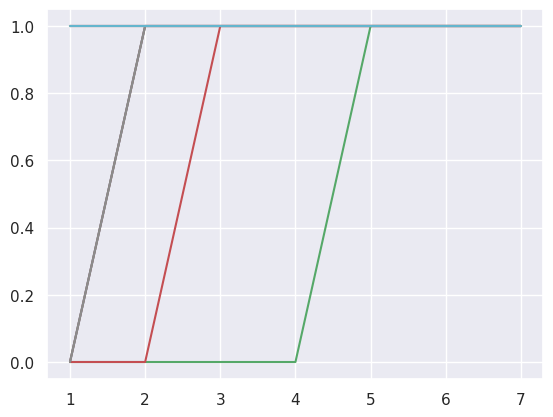

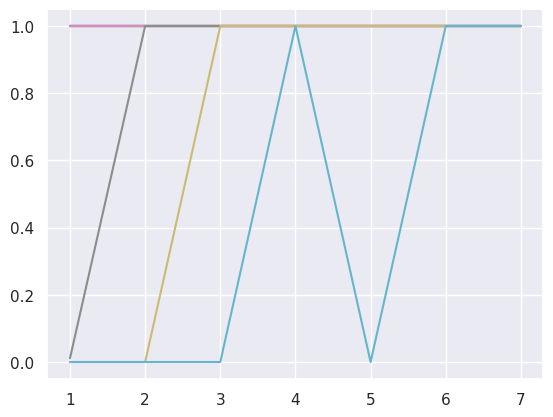

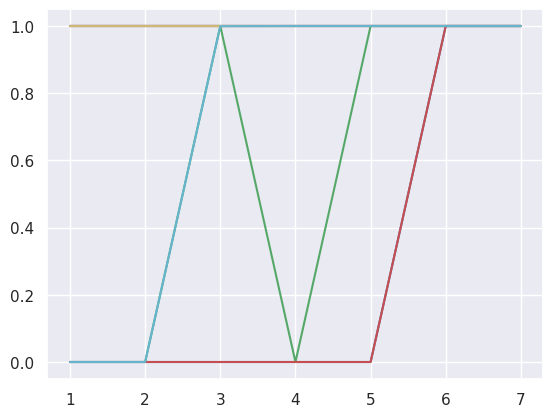

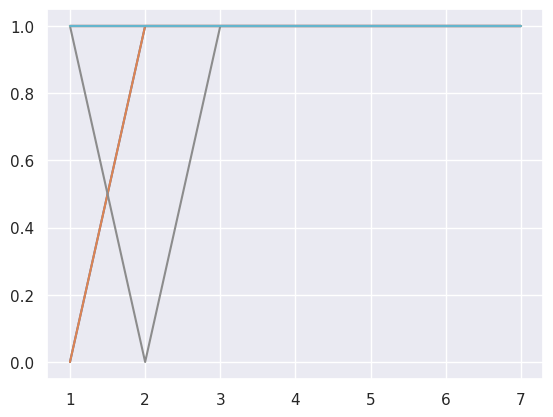

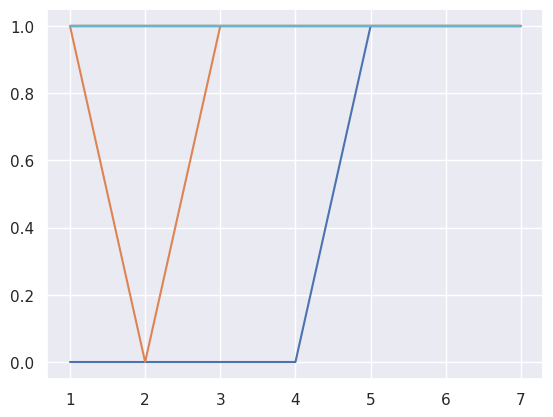

In [51]:
_preds = preds_poe_ovr_break_ties_tempered_softmax[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties_tempered_softmax

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

#### while softmax-tempering helps with rescaling the probabilities (see above), the calibration in terms of ECE remains poor (see below)

1
 ECE OVR: 0.001
 ECE OVR, break-ties: 0.570
 ECE OVR, break-ties, softmax-tempered: 0.345
2
 ECE OVR: 0.004
 ECE OVR, break-ties: 0.491
 ECE OVR, break-ties, softmax-tempered: 0.296
3
 ECE OVR: 0.005
 ECE OVR, break-ties: 0.353
 ECE OVR, break-ties, softmax-tempered: 0.269
4
 ECE OVR: 0.006
 ECE OVR, break-ties: 0.224
 ECE OVR, break-ties, softmax-tempered: 0.256
5
 ECE OVR: 0.007
 ECE OVR, break-ties: 0.130
 ECE OVR, break-ties, softmax-tempered: 0.245
6
 ECE OVR: 0.006
 ECE OVR, break-ties: 0.061
 ECE OVR, break-ties, softmax-tempered: 0.242
7
 ECE OVR: 0.006
 ECE OVR, break-ties: 0.026
 ECE OVR, break-ties, softmax-tempered: 0.240


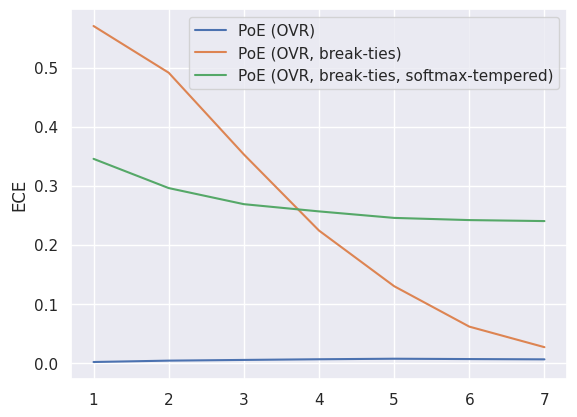

In [52]:
ece_poe_ovr, ece_poe_ovr_break_ties, ece_poe_ovr_break_ties_softmax_tempered = [], [], []
for l in range(L):
    _ece_poe_ovr = ECE(bins=15).measure(probs_poe_ovr[l, :, :].numpy(), targets.numpy())
    _ece_poe_ovr_break_ties = ECE(bins=15).measure(probs_poe_ovr_break_ties[l, :, :].numpy(), targets.numpy())
    _ece_poe_ovr_break_ties_softmax_tempered = ECE(bins=15).measure(probs_poe_ovr_break_ties_tempered_softmax[l, :, :].numpy(), targets.numpy())
    print(f'{l + 1}')
    print(f' ECE OVR: {_ece_poe_ovr:.3f}')
    print(f' ECE OVR, break-ties: {_ece_poe_ovr_break_ties:.3f}')
    print(f' ECE OVR, break-ties, softmax-tempered: {_ece_poe_ovr_break_ties_softmax_tempered:.3f}')
    ece_poe_ovr.append(_ece_poe_ovr)
    ece_poe_ovr_break_ties.append(_ece_poe_ovr_break_ties)
    ece_poe_ovr_break_ties_softmax_tempered.append(_ece_poe_ovr_break_ties_softmax_tempered)



plt.plot(list(range(1, L + 1)), ece_poe_ovr, label='PoE (OVR)')
plt.plot(list(range(1, L + 1)), ece_poe_ovr_break_ties, label='PoE (OVR, break-ties)')
plt.plot(list(range(1, L + 1)), ece_poe_ovr_break_ties_softmax_tempered, label='PoE (OVR, break-ties, softmax-tempered)')
plt.ylabel('ECE')
plt.legend()
plt.show()

### 2.6 Rankings plots

In [129]:
rankings_i

[99, 99, 99, 99, 99, 99, 99]

In [132]:
_probs[l, i, :].numpy().argsort()

array([ 0, 36, 39, 43, 52, 53, 55, 57, 58, 60, 61, 65, 68, 32, 70, 75, 76,
       82, 83, 85, 86, 87, 92, 94, 95, 96, 97, 72, 30, 49, 28, 17, 22, 23,
       16, 15, 13, 21, 25, 20,  5, 10,  9, 77, 50, 67,  1, 66, 69, 12, 31,
       98, 24, 42, 38, 27, 73, 99, 41, 47, 19, 84, 81, 91, 40, 35,  3, 74,
       80, 93, 71,  4, 62,  7, 90, 46, 59, 64, 89, 54, 11, 88, 63, 78, 18,
        2, 37, 51, 14, 48, 34,  8, 29,  6, 56, 33, 44, 79, 45, 26])

In [131]:
_preds[i]

tensor(26)

In [130]:
l, i = 0, 100
np.where(_probs[l, i, :].numpy().argsort() == int(_preds[i]))[0][0]

99

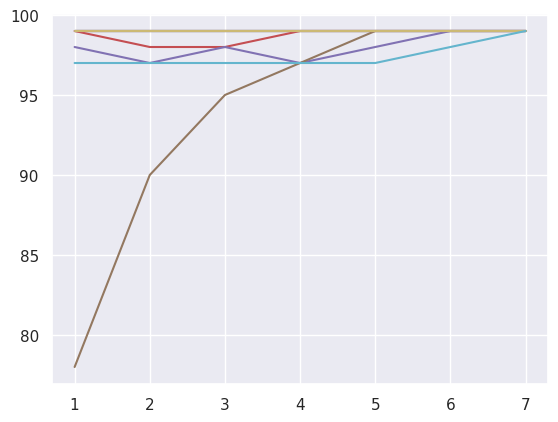

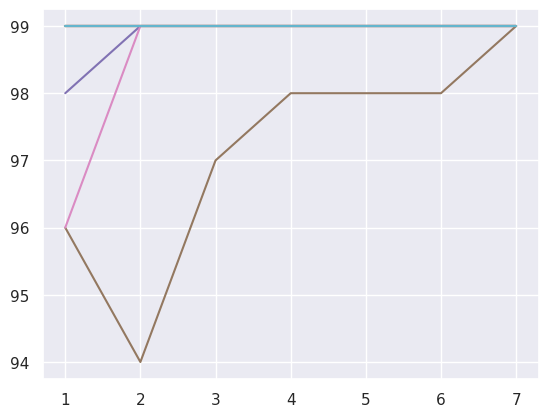

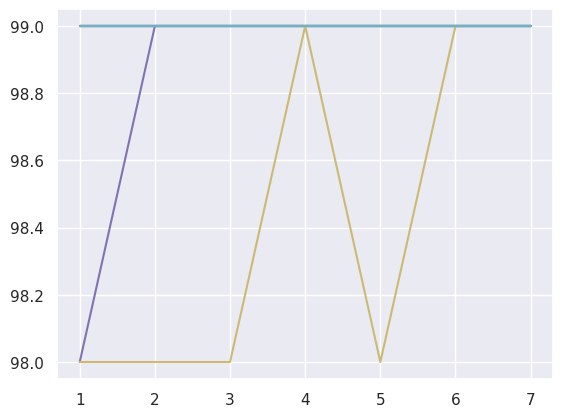

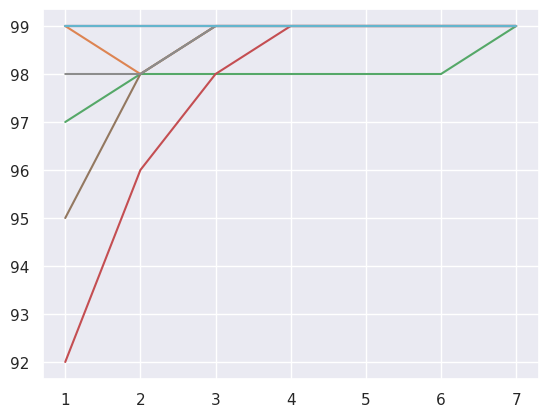

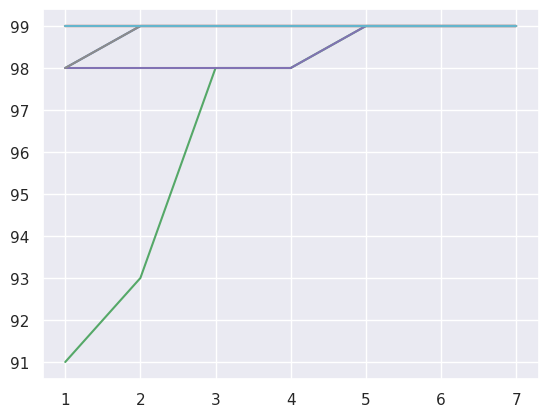

In [128]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    samples = random.sample(range(10000), 10)
    for i in samples:
        rankings_i = [np.where(_probs[l, i, :].numpy().argsort() == int(_preds[i]))[0][0] for l in range(L)]
        plt.plot(list(range(1, len(rankings_i) + 1)), rankings_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    plt.show()

PoE-OVR-break_ties
[(0, 9099), (1, 744), (2, 107), (3, 25), (4, 10)]
PoE-softmax
[(0, 9019), (1, 786), (2, 138), (3, 23), (4, 15)]
DE-softmax
[(0, 8671), (1, 1110), (2, 133), (3, 38), (4, 19)]


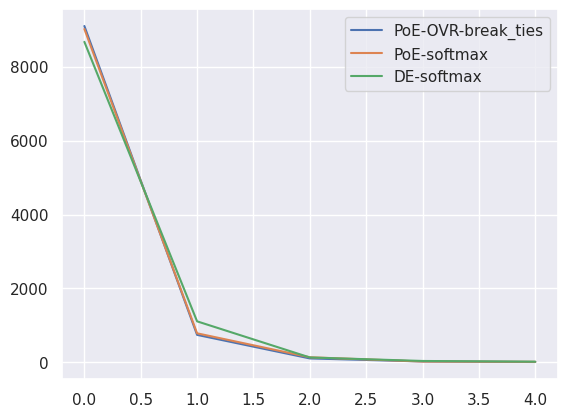

In [54]:
# # _preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs_poe_ovr_break_ties

# # _preds = preds[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs

# # _preds = preds_poe[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs_poe

# # _preds = preds_de[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
# _probs = probs_de


plot_targets = False
for _preds, _probs, name in [
                             # (preds[L - 1], probs, 'NN'),
                             (preds_poe_ovr_break_ties[L - 1], probs_poe_ovr_break_ties, 'PoE-OVR-break_ties'),
                            # (preds_poe_ovr[L - 1], probs_poe_ovr, 'PoE-OVR'),
                             
                             (preds_poe[L - 1], probs_poe, 'PoE-softmax'),
                             (preds_de[L - 1], probs_de, 'DE-softmax')
                             ]:
    if plot_targets:
        _preds = targets
    diffs = []
    for i in range(10000):
        rankings_i = [np.where(_probs[l, i, :].numpy().argsort() == int(_preds[i]))[0][0] for l in range(L)]
        diffs.append(np.diff(rankings_i).min())

    diffs = [-d for d in diffs]
    diffs = Counter(diffs)
    print(name)
    print(diffs.most_common()[:5])
    plt.plot(*zip(*diffs.most_common()[:5]), label=f'{name}')


# plt.plot([0, 1, 2, 3, 4], [10000, 0, 0, 0, 0], label='f*', linestyle='--', color='black')
plt.legend()
plt.show()

### 2.7 OVR break-ties (no PoE)

ablation study if PoE is indeed needed

In [55]:
probs_ovr_break_ties = torch.tensor(f_probs_ovr_logits_weighted(logits))
preds_ovr_break_ties = {i: torch.argmax(probs_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_ovr_break_ties = [(targets == preds_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [56]:
acc_ovr_break_ties

[tensor(0.6513),
 tensor(0.6811),
 tensor(0.7065),
 tensor(0.7223),
 tensor(0.7264),
 tensor(0.7286),
 tensor(0.7286)]

### 2.8 break-ties OVR generalized

In [57]:
# probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.arange(1, L + 1, 1, dtype=float)))
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.arange(1, L + 1, 1, dtype=float) / (L * (L + 1) / 2)))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

## 3 Summary

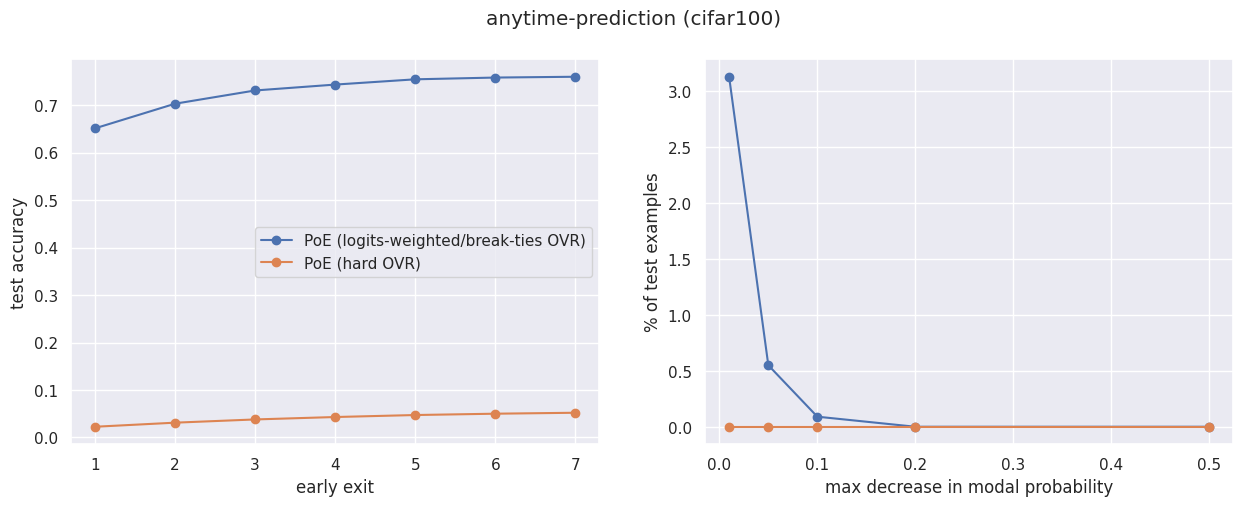

In [58]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
# ax[0].plot(early_exits, acc_de, label='DE (softmax)', marker='o')
# ax[0].plot(early_exits, acc_poe, label='PoE (softmax)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (logits-weighted/break-ties OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr, label='PoE (hard OVR)', marker='o')
# ax[0].plot(early_exits, acc_ovr_break_ties, label='NN (OVR, break-ties)', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr_fallback_ood, label='PoE (OVR, fall-back)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            # (preds, probs, 'NN (softmax)'), 
                            # (preds_de, probs_de, 'DE (softmax)'), 
                            # (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (logits-weighted/break-ties OVR)'),
                            (preds_poe_ovr, probs_poe_ovr, 'PoE (hard OVR)'),
                            # (preds_ovr_break_ties, probs_ovr_break_ties, 'NN (OVR, break-ties)'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

### 3.1 poor calibration

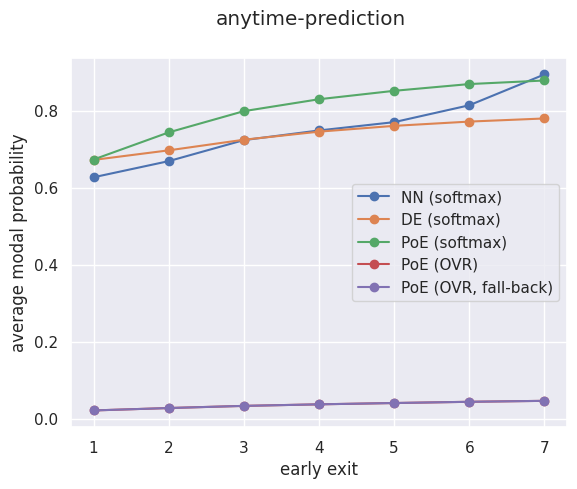

In [59]:
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_de, probs_de, 'DE (softmax)'), 
                            (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            # (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                            (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L)
    plt.plot(early_exits, modal_probs.numpy(), marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('average modal probability')


plt.suptitle('anytime-prediction')
plt.show()

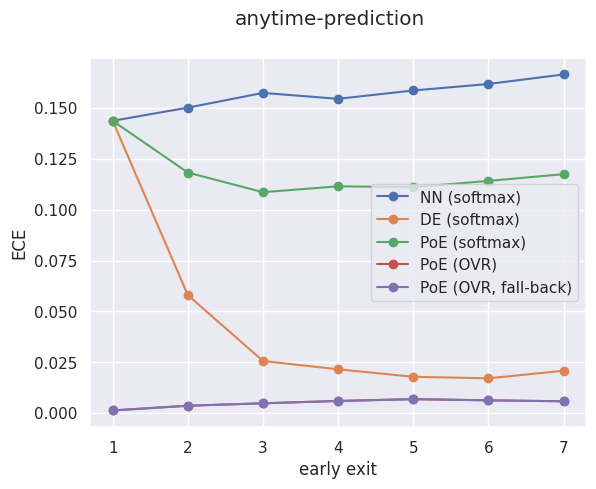

In [60]:
early_exits = [i + 1 for i in range(len(acc))]
for _probs, label in [
                      (probs, 'NN (softmax)'),  
                      (probs_de, 'DE (softmax)'), 
                      (probs_poe, 'PoE (softmax)'),
                      (probs_poe_ovr, 'PoE (OVR)'),
                      # (probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                      (probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                      ]:
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    plt.plot(early_exits, ece, marker='o', label=label)
plt.legend()
plt.xlabel('early exit')
plt.ylabel('ECE')

plt.suptitle('anytime-prediction')
plt.show()

### 3.1 hard OVR vs break-ties OVR

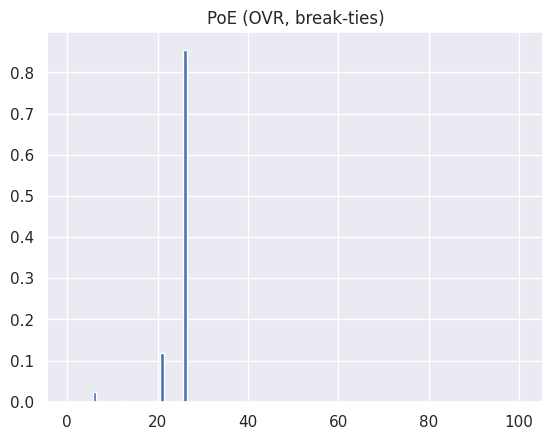

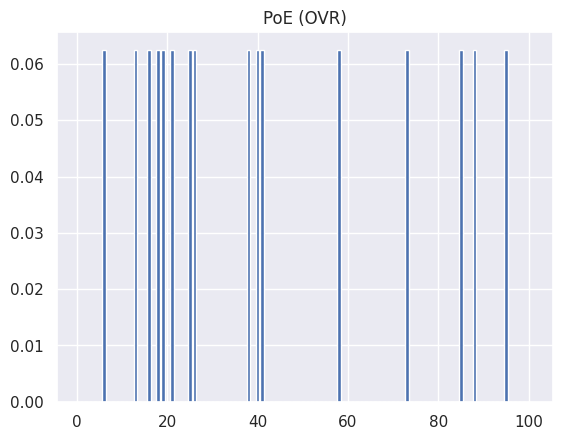

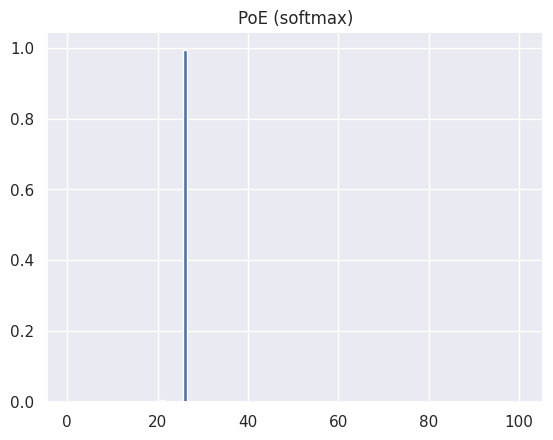

In [61]:
l, n = 6, 110

plt.bar(np.arange(1, ARGS.num_classes + 1, 1), probs_poe_ovr_break_ties[l, n, :].numpy())
plt.title('PoE (OVR, break-ties)')
plt.show()

plt.bar(np.arange(1, ARGS.num_classes + 1, 1), probs_poe_ovr[l, n, :].numpy())
plt.title('PoE (OVR)')
plt.show()

plt.bar(np.arange(1, ARGS.num_classes + 1, 1), probs_poe[l, n, :].numpy())
plt.title('PoE (softmax)')
plt.show()

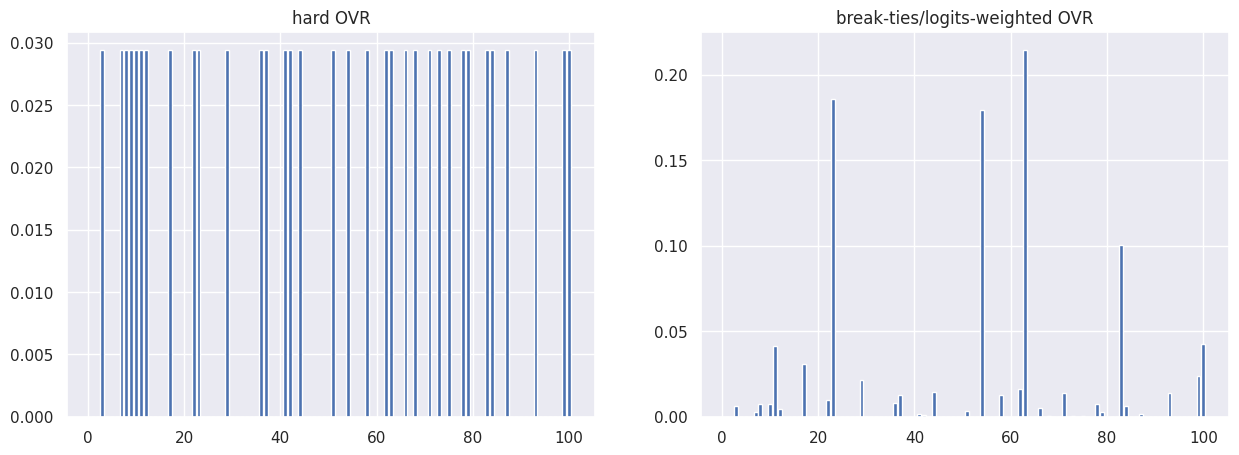

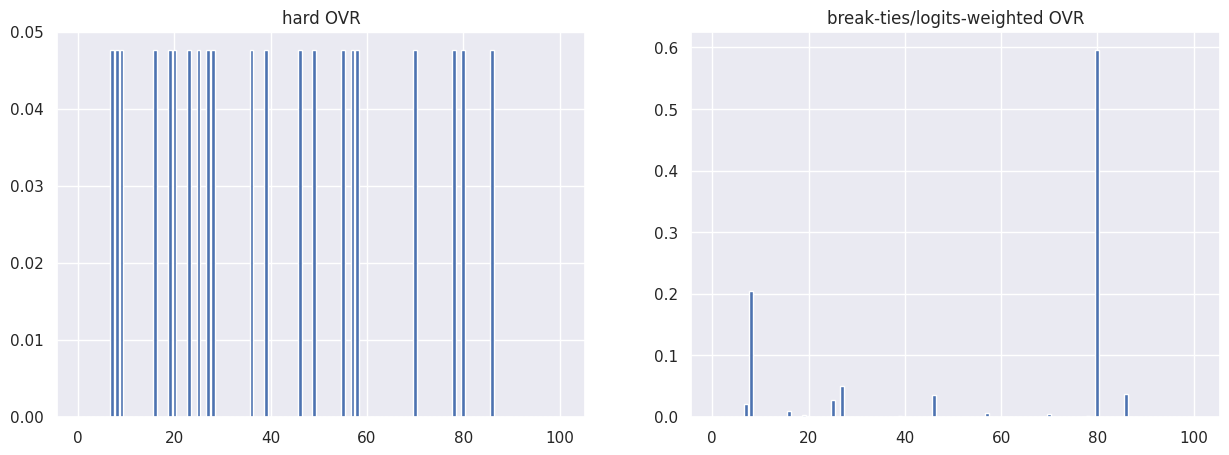

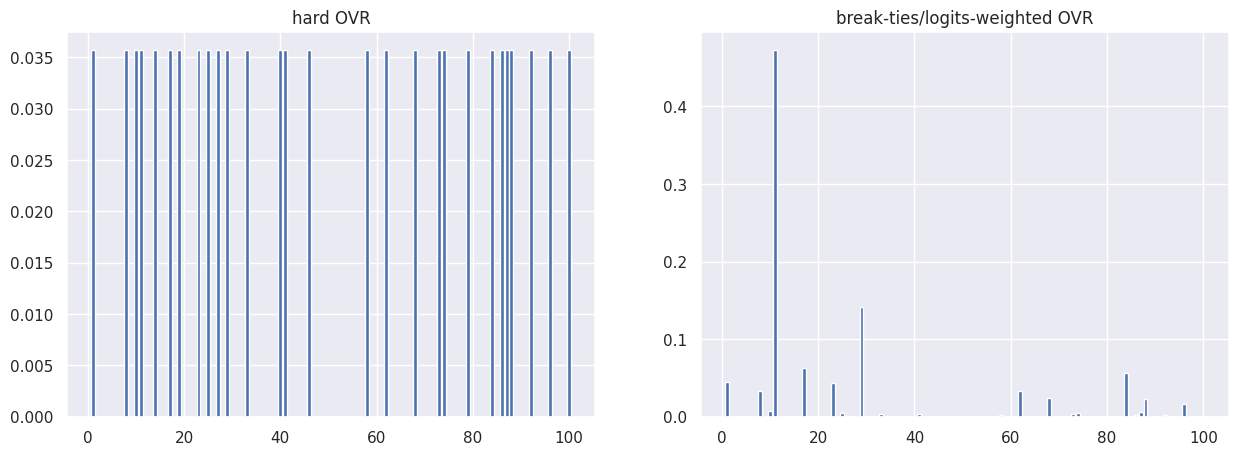

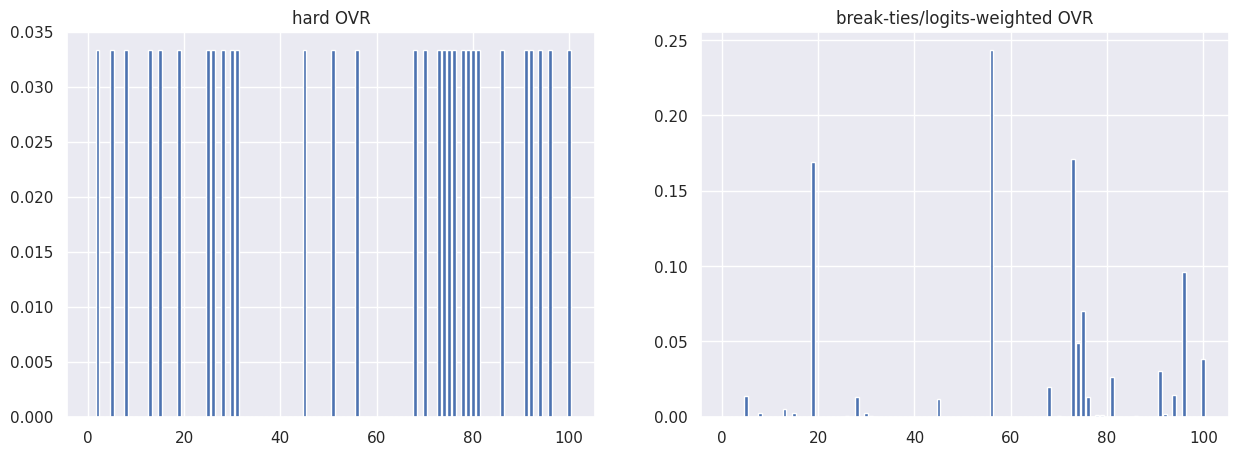

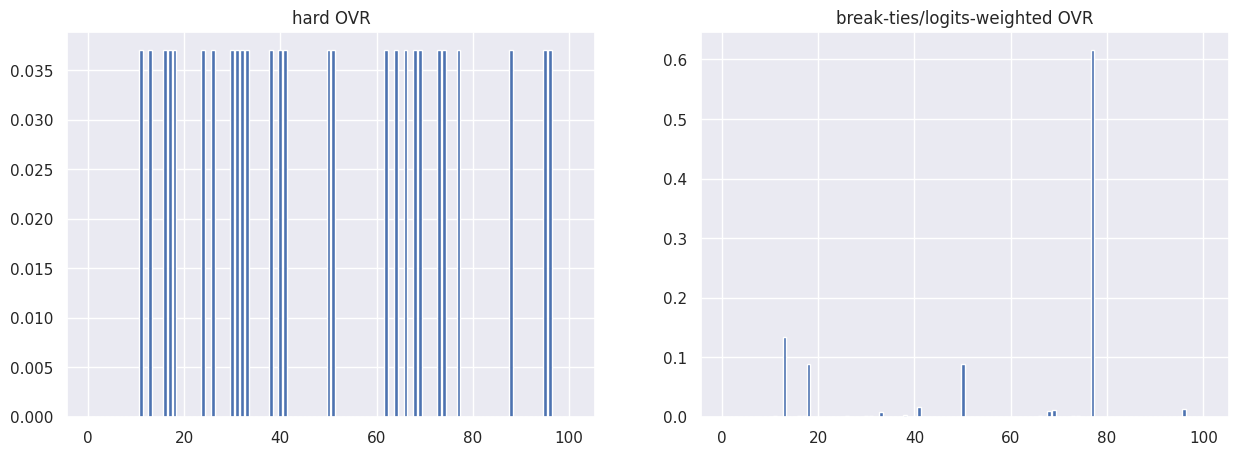

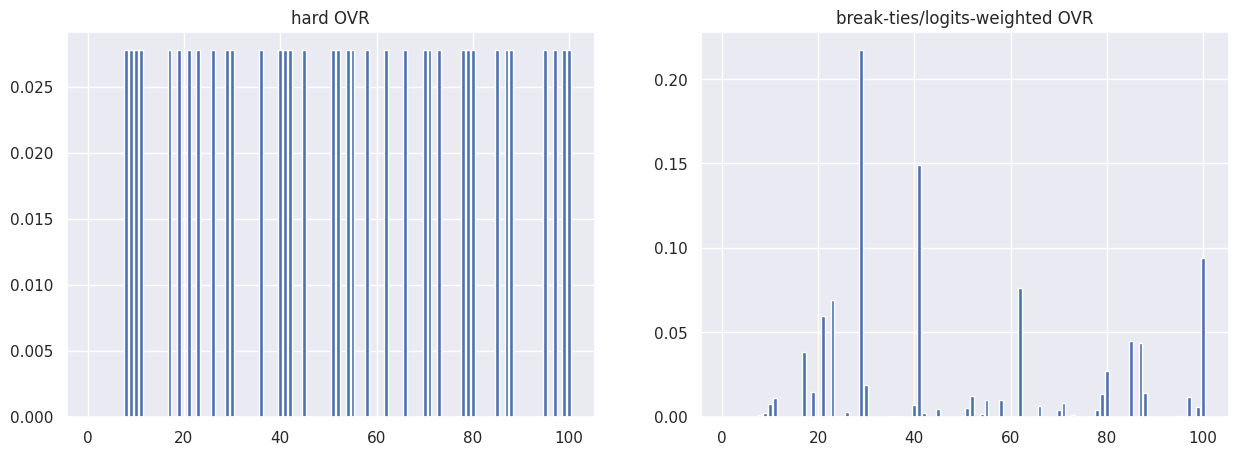

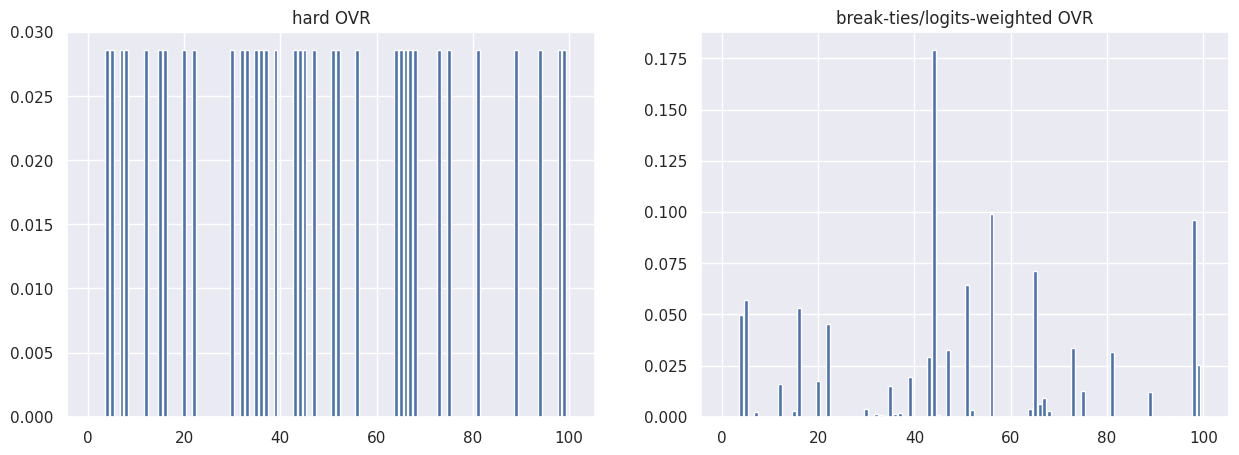

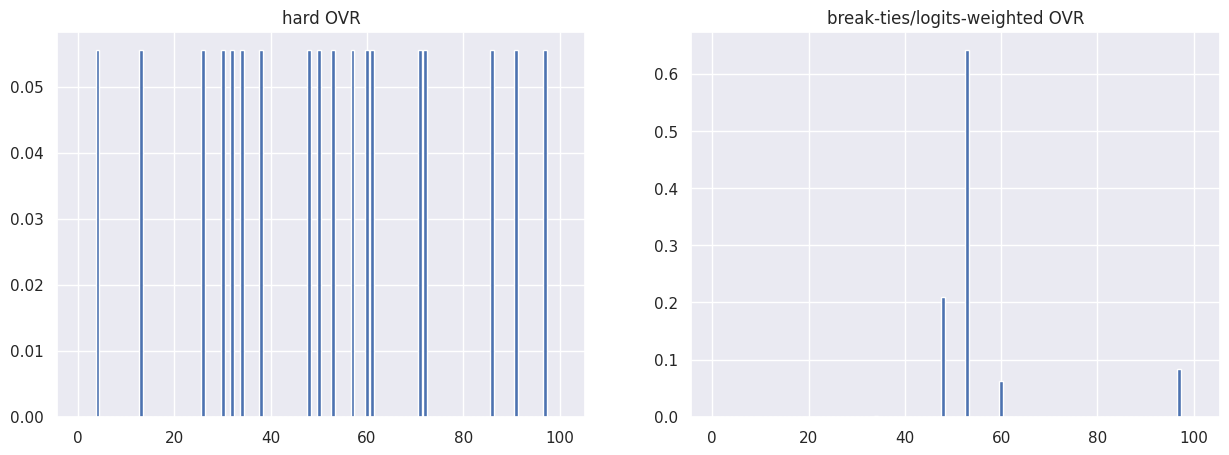

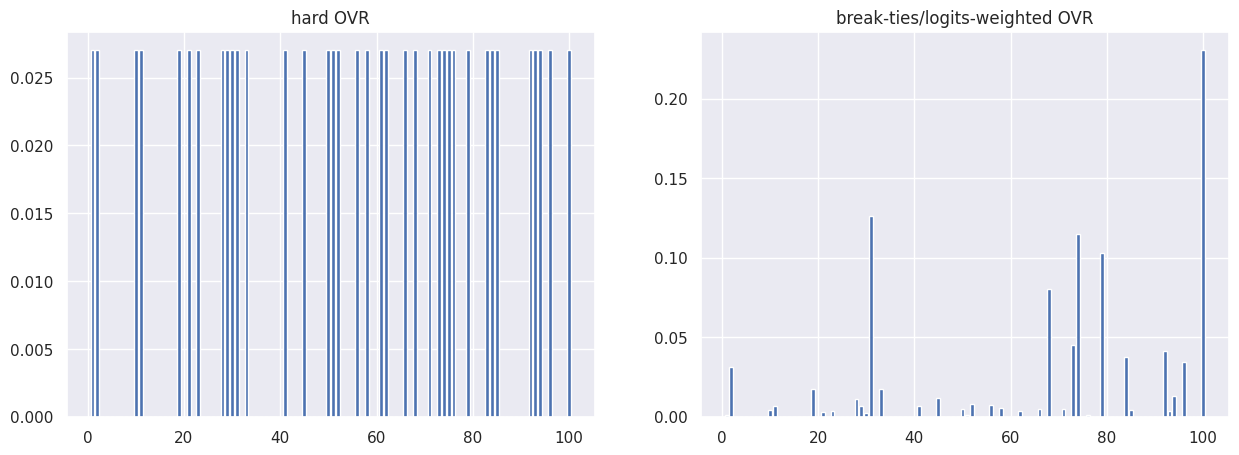

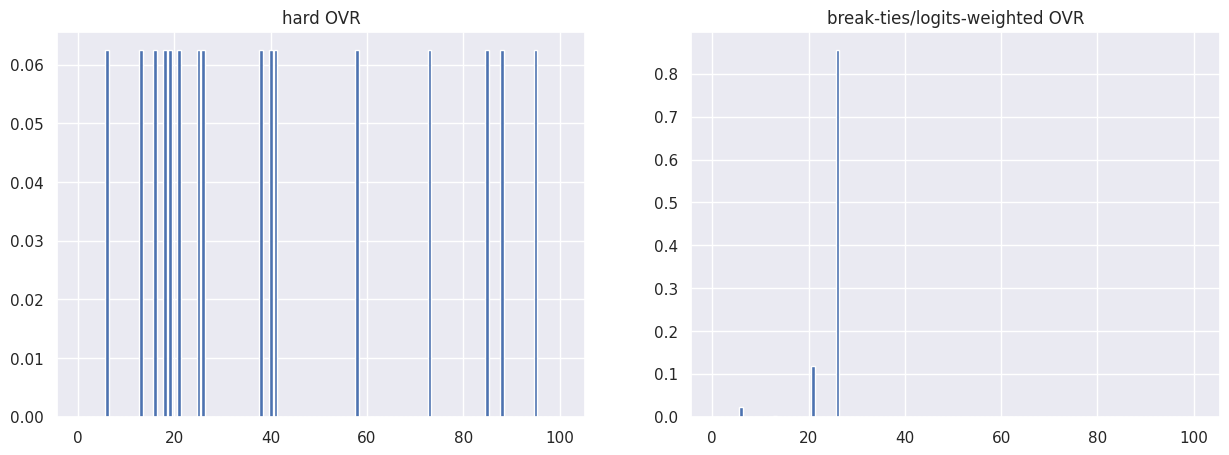

In [62]:
for _ in range(10):
    l = random.sample(range(L), 1)
    n = random.sample(range(10000), 1)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    _break_ties_ovr = probs_poe_ovr_break_ties[l, n, :].numpy()
    _hard_ovr = probs_poe_ovr[l, n, :].numpy()
    assert np.all(np.equal((_break_ties_ovr > 0), (_hard_ovr > 0)))
    ax[0].bar(np.arange(1, ARGS.num_classes + 1, 1), _hard_ovr.reshape(-1))
    ax[1].bar(np.arange(1, ARGS.num_classes + 1, 1), _break_ties_ovr.reshape(-1))
    ax[0].set_title('hard OVR')
    ax[1].set_title('break-ties/logits-weighted OVR')
    plt.show()

### 3.2 presentation plots

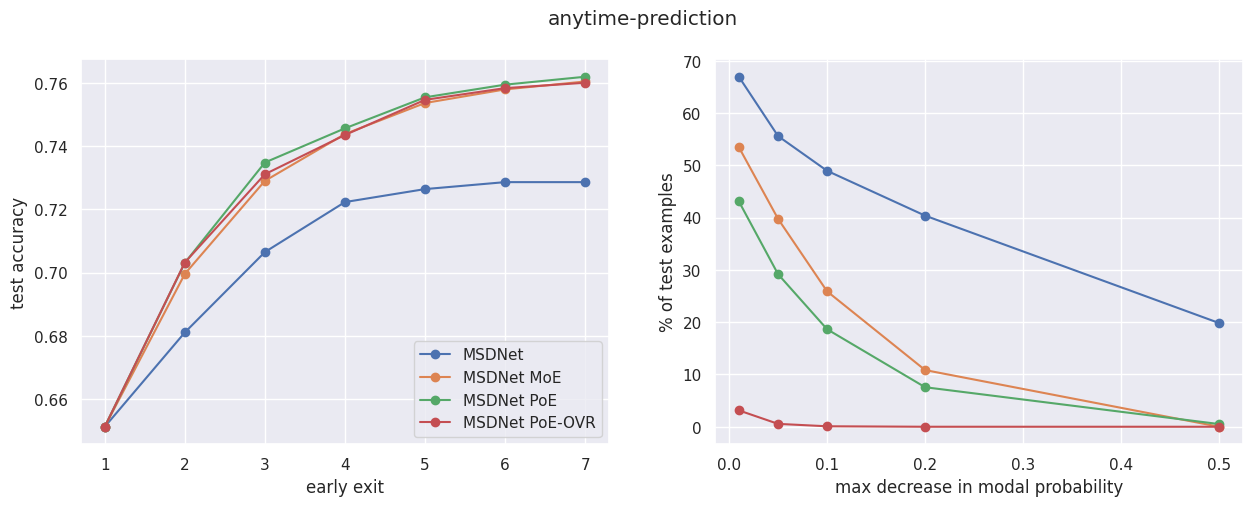

In [63]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='MSDNet', marker='o',)
ax[0].plot(early_exits, acc_de, label='MSDNet MoE', marker='o')
ax[0].plot(early_exits, acc_poe, label='MSDNet PoE', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr, label='PoE (OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='MSDNet PoE-OVR', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr_fallback_ood, label='PoE (OVR, fall-back)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'MSDNet'), 
                            (preds_de, probs_de, 'MSDNet MoE'), 
                            (preds_poe, probs_poe, 'MSDNet PoE'),
                            # (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'MSDNet PoE-OVR'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('anytime-prediction')
plt.show()

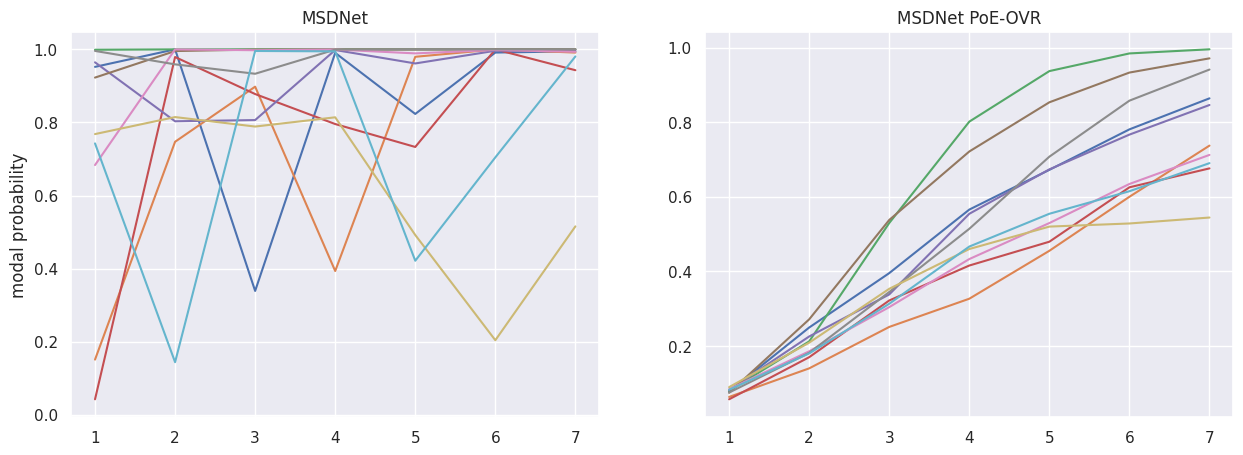

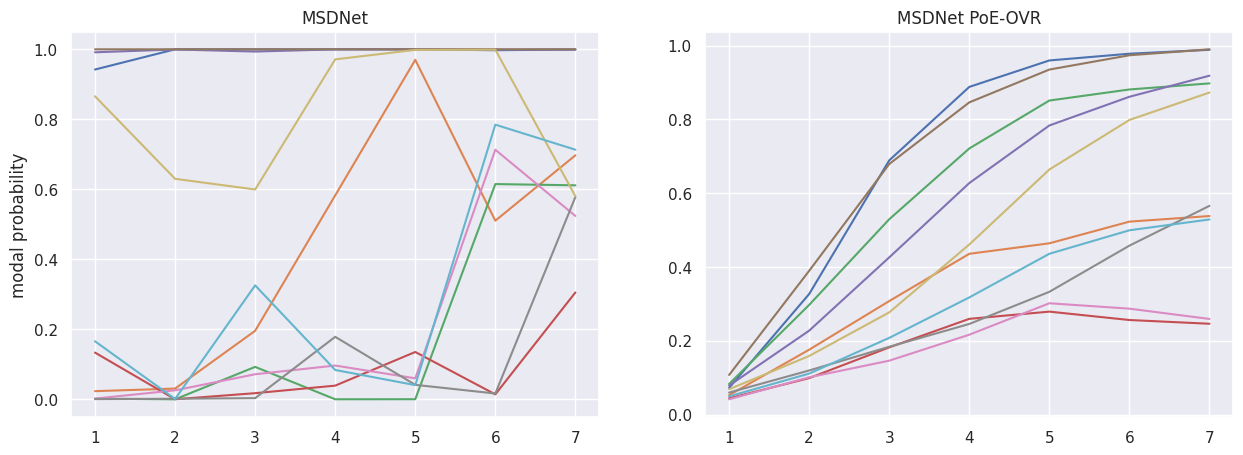

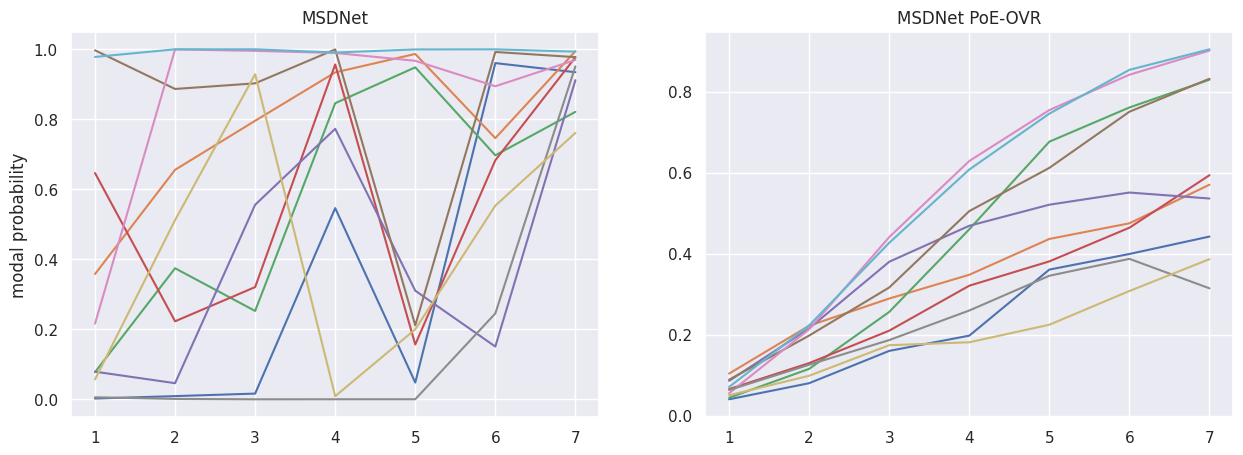

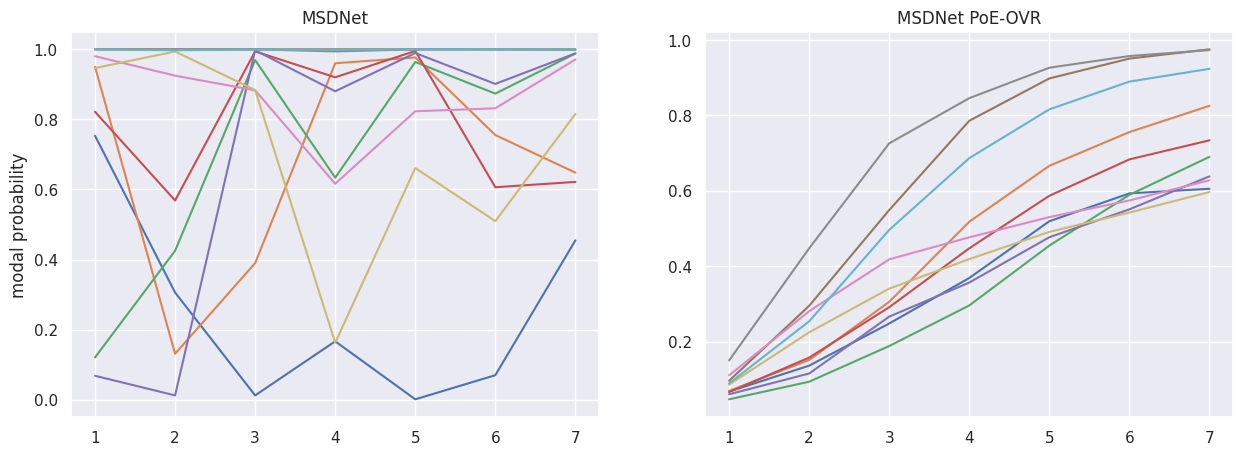

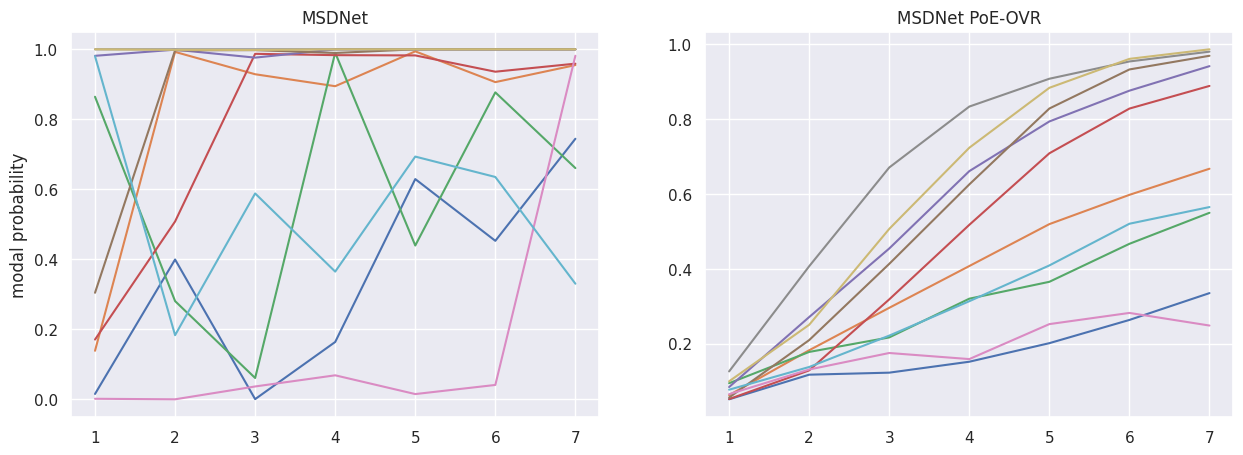

In [64]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('MSDNet')
    ax[1].set_title('MSDNet PoE-OVR')
    ax[0].set_ylabel('modal probability')
    plt.show()

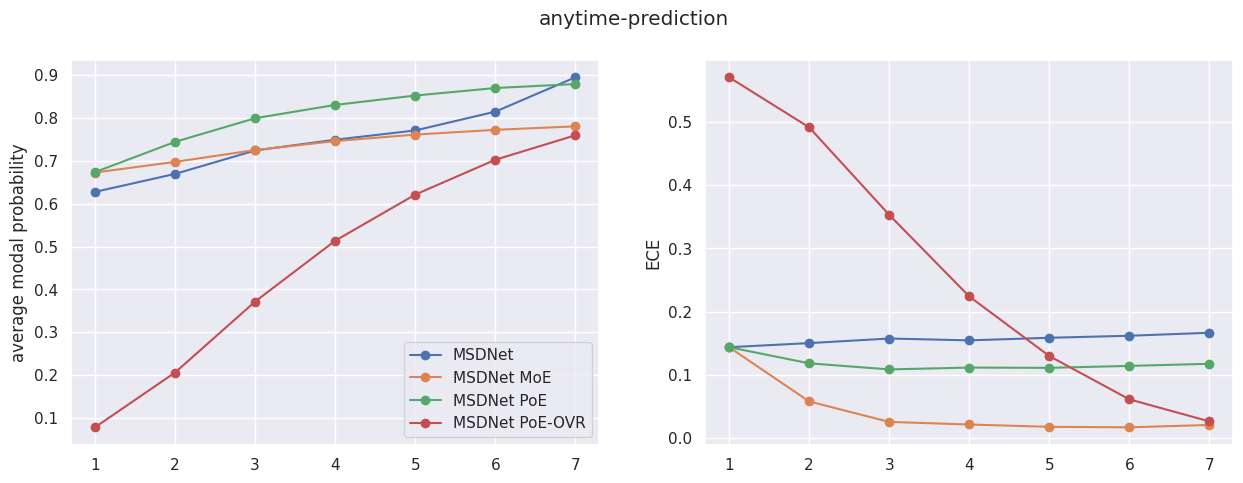

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'MSDNet'), 
                            (preds_de, probs_de, 'MSDNet MoE'), 
                            (preds_poe, probs_poe, 'MSDNet PoE'),
                            # (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'MSDNet PoE-OVR'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L)
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, modal_probs.numpy(), marker='o', label=label)
    ax[1].plot(early_exits, ece, marker='o', label=label)
ax[0].legend()
ax[0].set_ylabel('average modal probability')
ax[1].set_ylabel('ECE')


plt.suptitle('anytime-prediction')
plt.show()

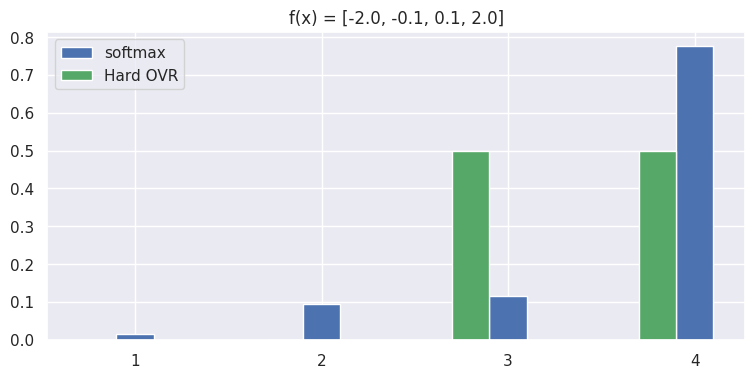

In [66]:
a = torch.tensor([-2., -0.1, 0.1, 2.])
b = torch.softmax(a, dim=0).numpy()
c = (torch.sigmoid(a).round() / 2).numpy()
x = np.arange(1, 5, 1)

fig, ax = plt.subplots(figsize=(9, 4))
plt.bar(x, b, width=0.2, color='b', align='center', label='softmax')
plt.bar(x-0.2, c, width=0.2, color='g', align='center', label='Hard OVR')
plt.xticks(x, [1, 2, 3, 4])
plt.title('f(x) = [-2.0, -0.1, 0.1, 2.0]')
plt.legend()
plt.show()

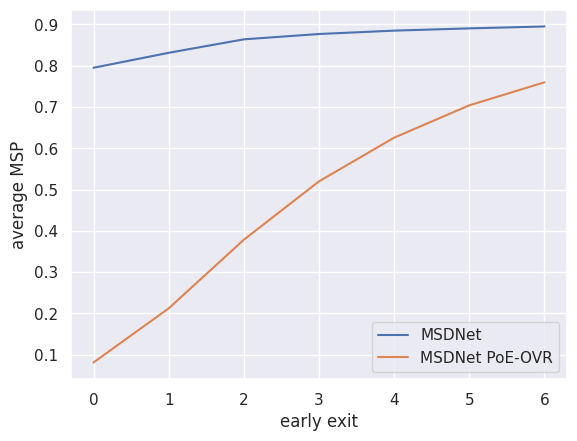

In [67]:
plt.plot(list(range(len(msp))), [msp[j].mean() for j in range(len(msp))], label='MSDNet')
plt.plot(list(range(len(msp_poe_ovr_break_ties))), [msp_poe_ovr_break_ties[j].mean() for j in range(len(msp_poe_ovr_break_ties))], label='MSDNet PoE-OVR')
plt.legend()
plt.xlabel('early exit')
plt.ylabel('average MSP')
plt.show()


### 3.3 performance gap of PoE-OVR-break_ties vs MSDNet

In [68]:
(preds[0] == targets).sum()

tensor(6513)

In [69]:
(preds_poe_ovr_break_ties[0] == targets).sum()

tensor(6513)

In [70]:
(preds[0] == preds_poe_ovr_break_ties[0])[119]

tensor(True)

In [71]:
(logits[0, 119, :]).argmax()

tensor(56)

In [72]:
torch.softmax(logits[0, 119, :], dim=0).argmax()

tensor(56)

In [73]:
torch.sigmoid(logits[0, 119, :]).argmax()

tensor(45)

In [74]:
modal_probs = modal_probs_decreasing(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, L, verbose=True)

2 [0.04672527 0.10851791 0.18305016 0.29431957 0.36523774 0.3098815
 0.2816471 ]
2 [0.04672527 0.10851791 0.18305016 0.29431957 0.36523774 0.3098815
 0.2816471 ]
29 [0.05432634 0.15960352 0.2217147  0.2827818  0.40998068 0.45914474
 0.36846215]
29 [0.05432634 0.15960352 0.2217147  0.2827818  0.40998068 0.45914474
 0.36846215]
42 [0.04798095 0.10975152 0.24234684 0.32314378 0.29390585 0.4124652
 0.5437959 ]
84 [0.06504268 0.11899257 0.16737849 0.25396    0.31227773 0.30836695
 0.29575518]
101 [0.08594412 0.20528546 0.32388684 0.41891414 0.46568117 0.49143085
 0.47596803]
103 [0.07927923 0.21645176 0.3575363  0.48413736 0.60213304 0.6329784
 0.6082652 ]
121 [0.05178588 0.10657112 0.15148652 0.18075834 0.22526999 0.21424823
 0.23365398]
123 [0.08339456 0.19811852 0.32888368 0.41099092 0.48809728 0.5242507
 0.4873395 ]
134 [0.06423896 0.12122695 0.21307461 0.26898673 0.36498004 0.43726438
 0.36739808]
134 [0.06423896 0.12122695 0.21307461 0.26898673 0.36498004 0.43726438
 0.36739808]
196 [

In [75]:
modal_probs

{0.01: 3.1300000000000003,
 0.05: 0.5499999999999999,
 0.1: 0.09,
 0.2: 0.0,
 0.5: 0.0}

In [76]:
probs_poe_ovr_break_ties[6, 2, :]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2329e-07, 1.8082e-02, 0.0000e+00,
        0.0000e+00, 2.6552e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4886e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0662e-06,
        4.2976e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5299e-03, 0.0000e+00, 7.5227e-02, 7.0860e-02, 0.0000e+00, 0.0000e+00,
        1.1603e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.8165e-01, 5.3233e-03, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.7532e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0842e-06, 0.0000e+00, 7.9361e-05, 0.0000e+00, 0.0000e+00,
        1.7875e-01, 1.7326e-02, 6.6075e-

In [77]:
for l in range(L):
    print((logits[l, 2, :] > 0).sum())

tensor(50)
tensor(53)
tensor(41)
tensor(48)
tensor(42)
tensor(50)
tensor(47)


## 4 Sort images w.r.t. modal probability

In [78]:
_, _, _test_loader = get_dataloaders(ARGS, normalize=False)

Files already downloaded and verified
Files already downloaded and verified
!!!!!! Load train_set_index !!!!!!


In [79]:
LABEL = 1

label_ids = np.where(targets.numpy() == LABEL)[0]
test_images = []
for x, _ in _test_loader:
    test_images.append(x.cuda())
test_images = torch.concat(test_images, dim=0)
test_images = test_images[label_ids, :, :, :]

In [80]:
test_images.shape

torch.Size([100, 3, 32, 32])

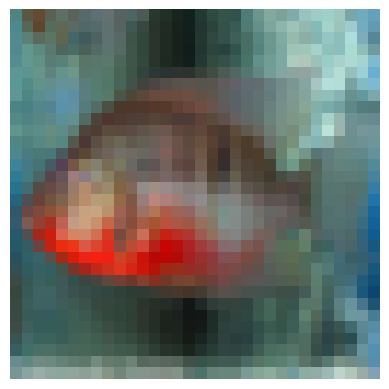

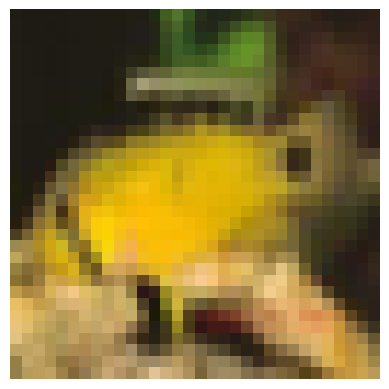

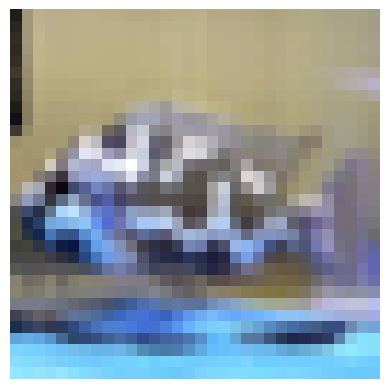

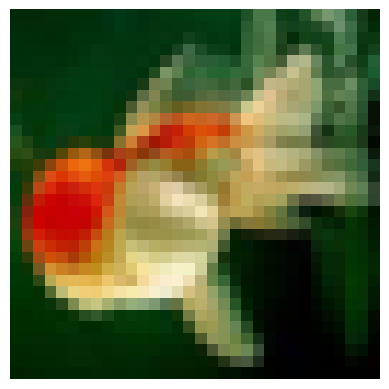

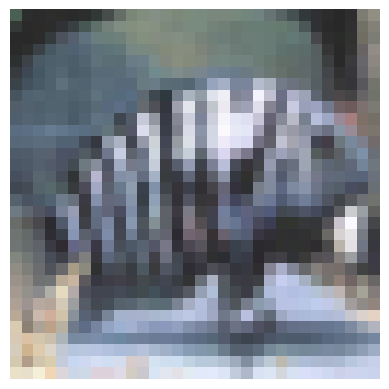

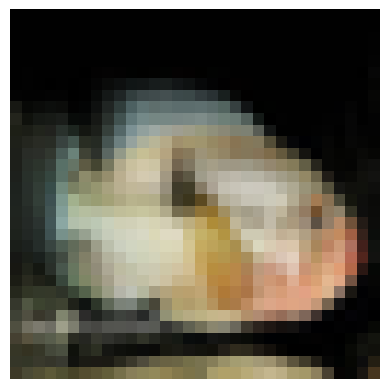

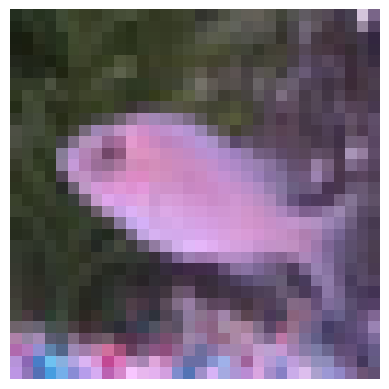

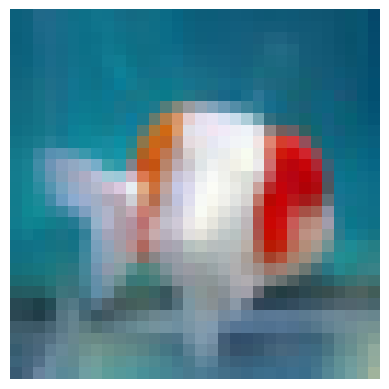

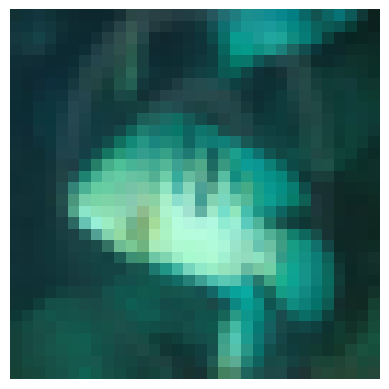

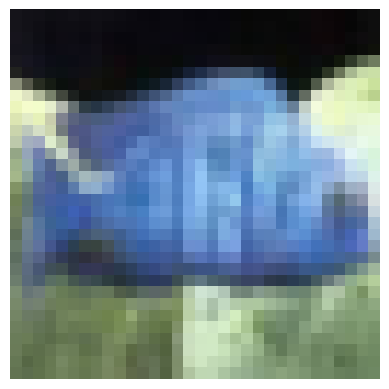

In [81]:
# plot test images
for i in range(10):
    plt.imshow(test_images[i, :, :, :].cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.show()

### Do easy examples have larger modal probabilities?

Note that this is important if we are to use probability measures (e.g. MSP) as a termination criteria

to measure "hardness" of the example, look at the ranking of the ground-truth:

        - easy examples should exhibit high ranking of the ground-truth
    
        - hard examples should exhibit low ranking of the ground-truth


In [82]:
# _preds = preds[L - 1]  # modal pred: p(\bar{y})
# _probs = probs

_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
_probs = probs_poe_ovr_break_ties

ranking_target = []
ranking_modal = []
prob_modal = []
for i in range(10000):
    ranking_target.append(np.where(_probs[L - 1, i, :].numpy().argsort() == int(targets[i]))[0][0])
    ranking_modal.append(np.where(_probs[L - 1, i, :].numpy().argsort() == int(_preds[i]))[0][0])
    prob_modal.append(_probs[L - 1, i, int(_preds[i])])

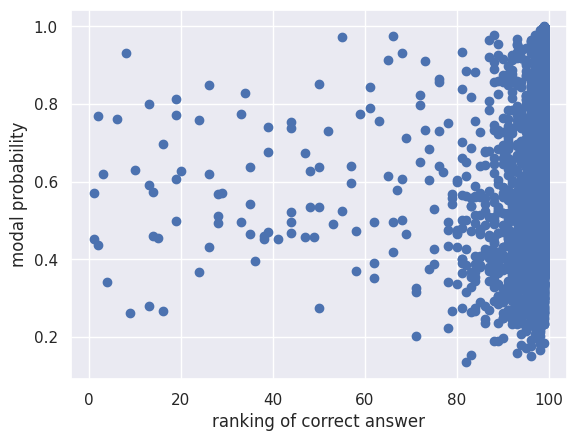

In [83]:
plt.scatter(ranking_target, prob_modal)
plt.xlabel('ranking of correct answer')
plt.ylabel('modal probability')
plt.show()

In [84]:
from scipy.stats import spearmanr, kendalltau

In [85]:
np.corrcoef(ranking_target, prob_modal), spearmanr(ranking_target, prob_modal), kendalltau(ranking_target, prob_modal)

(array([[1.        , 0.20089585],
        [0.20089585, 1.        ]]),
 SignificanceResult(statistic=0.5350913869564752, pvalue=0.0),
 SignificanceResult(statistic=0.42090566722764444, pvalue=0.0))

### Do easy examples have smaller predictive sets?

In [86]:
# _preds = preds[L - 1]  # modal pred: p(\bar{y})
# _probs = probs

_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
_probs = probs_poe_ovr_break_ties

ranking_target = []
correct = []
predictive_set_size = []
for i in range(10000):
    ranking_target.append(np.where(_probs[L - 4, i, :].numpy().argsort() == int(targets[i]))[0][0])
    predictive_set_size.append((_probs[L - 4, i, :].numpy() > 0).sum())
    correct.append(int(_preds[i] == targets[i]))

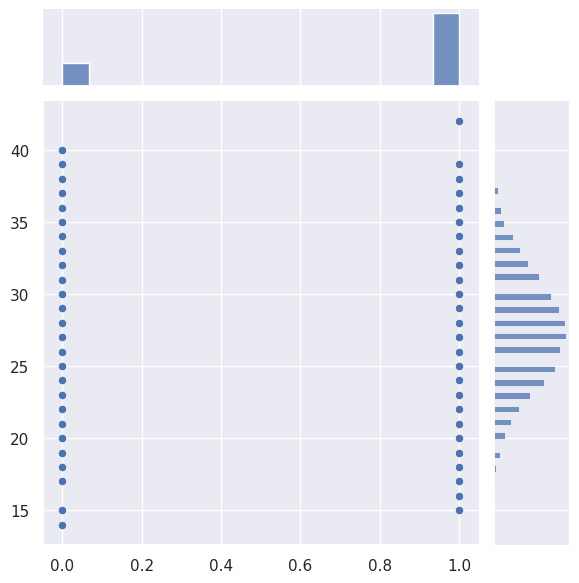

In [87]:
sns.jointplot(x=correct, y=predictive_set_size)
# plt.scatter(ranking_target, predictive_set_size)
plt.show()

In [88]:
kendalltau(correct, predictive_set_size)

SignificanceResult(statistic=-0.05590051784331764, pvalue=3.8621064639847157e-11)

In [89]:
np.mean([predictive_set_size[i] for i in range(10000) if correct[i] == 1])

27.360657894736843

In [90]:
np.mean([predictive_set_size[i] for i in range(10000) if correct[i] == 0])

27.967083333333335

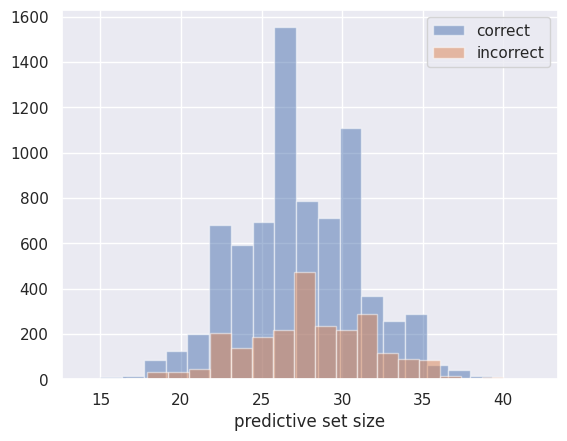

In [91]:
plt.hist([predictive_set_size[i] for i in range(10000) if correct[i] == 1], bins=20, alpha=0.5, label='correct')
plt.hist([predictive_set_size[i] for i in range(10000) if correct[i] == 0], bins=20, alpha=0.5, label='incorrect')
plt.xlabel('predictive set size')
plt.legend()
plt.show()

## 5 Random Early Exit experiment

In [92]:
random_ee_preds = []
random_ee_preds_ovr_break_ties = []
for i in range(10000):
    random_ee = np.random.randint(0, L)
    random_ee_preds.append(preds[random_ee][i])
    random_ee_preds_ovr_break_ties.append(preds_poe_ovr_break_ties[random_ee][i])
    # random_ee_preds_ovr_break_ties.append(preds_poe[random_ee][i])
random_ee_preds = torch.stack(random_ee_preds, dim=0)
random_ee_preds_ovr_break_ties = torch.stack(random_ee_preds_ovr_break_ties, dim=0)

In [93]:
(targets == random_ee_preds).sum()

tensor(7019)

In [94]:
(targets == random_ee_preds_ovr_break_ties).sum()

tensor(7272)

## 6 ground-truth coverage of OVR predictive sets

In [95]:
N = len(targets)
THRES = [0., 1., 2., 3., 4., 5.]

In [96]:
thres_dict = {}
for thres in tqdm(THRES):
    _probs = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=thres))
    _preds = {i: torch.argmax(_probs, dim=2)[i, :] for i in range(L)}
    _acc = [(targets == _preds[i]).sum() / len(targets) for i in range(L)]
    _modal_probs = modal_probs_decreasing(_preds, _probs, L)

    groud_truth_coverage = {l: 0 for l in range(L)}
    predictive_set_size = {l: [] for l in range(L)}
    for l in range(L):
        for n in range(N):
            if _probs[l, n, targets[n]] > 0.:
                groud_truth_coverage[l] += 1
            predictive_set_size[l].append((_probs[l, n, :] > 0).sum())

    predictive_set_size = {l: torch.stack(sizes, dim=0) for l, sizes in predictive_set_size.items()}
    predictive_set_size_mean = {l: sizes.numpy().mean() for l, sizes in predictive_set_size.items()}
    groud_truth_coverage_pct = {l: (x / N) for l, x in groud_truth_coverage.items()}
    thres_dict[thres] = (groud_truth_coverage_pct, predictive_set_size_mean, _acc, _modal_probs)

 67%|██████▋   | 4/6 [00:13<00:06,  3.24s/it]/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:114: RuntimeWarning: invalid value encountered in divide
  probs = (probs / np.repeat(probs.sum(axis=2)[:, :, np.newaxis], C, axis=2))
100%|██████████| 6/6 [00:19<00:00,  3.28s/it]


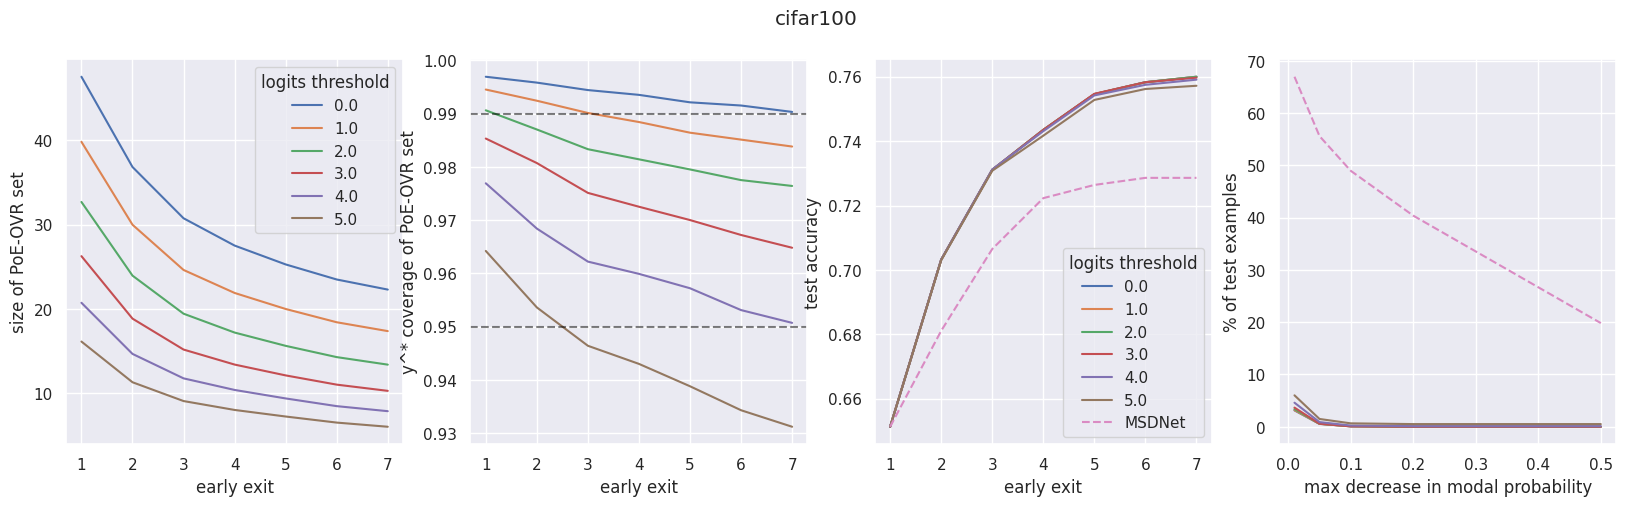

In [97]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for thres in THRES:
    ax[0].plot([x + 1 for x in thres_dict[thres][1].keys()], list(thres_dict[thres][1].values()), label=thres)
    ax[1].plot([x + 1 for x in thres_dict[thres][0].keys()], list(thres_dict[thres][0].values()), label=thres)
    ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], thres_dict[thres][2], label=thres)
    ax[3].plot(thres_dict[thres][3].keys(), thres_dict[thres][3].values(), label=thres)
ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], acc, label='MSDNet', linestyle='--')
_modal_probs = modal_probs_decreasing(preds, probs, L)
ax[3].plot(_modal_probs.keys(), _modal_probs.values(), label='MSDNets', linestyle='--')
ax[0].legend(title='logits threshold')
ax[2].legend(title='logits threshold')
ax[0].set_ylabel('size of PoE-OVR set')
ax[1].set_ylabel('y^* coverage of PoE-OVR set')
ax[2].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')
ax[1].set_xlabel('early exit')
ax[2].set_xlabel('early exit')
ax[3].set_xlabel('max decrease in modal probability')
ax[3].set_ylabel('% of test examples')

ax[1].axhline(y=0.99, color='black', linestyle='--', alpha=0.5)
ax[1].axhline(y=0.95, color='black', linestyle='--', alpha=0.5)
plt.suptitle(ARGS.data)
plt.show()

## 7 relative improvement of consecutive early exits

In [98]:
(torch.stack(acc)[1:] / torch.stack(acc)[:-1]) - 1.

tensor([0.0458, 0.0373, 0.0224, 0.0057, 0.0030, 0.0000])

In [99]:
rel_improvement_cifar10 = [ 0.0294,  0.0184,  0.0040,  0.0013, -0.0105,  0.0006]
rel_improvement_cifar100 = [0.0458, 0.0373, 0.0224, 0.0057, 0.0030, 0.0000]
rel_improvement_image_net_step_7 = [0.1180, 0.0382, 0.0081, 0.0136, None, None]
rel_improvement_image_net_step_4 = [0.1502, 0.0504, 0.0197, 0.0224, None, None]

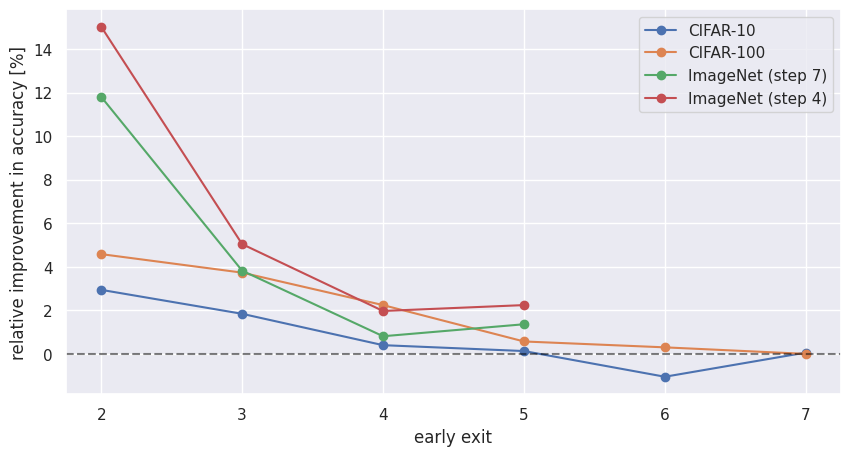

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot([2, 3, 4, 5, 6, 7], [x * 100 for x in rel_improvement_cifar10], label='CIFAR-10', marker='o')
plt.plot([2, 3, 4, 5, 6, 7], [x * 100 for x in rel_improvement_cifar100], label='CIFAR-100', marker='o')
plt.plot([2, 3, 4, 5, 6, 7], [x * 100 if x else None for x in rel_improvement_image_net_step_7], label='ImageNet (step 7)', marker='o')
plt.plot([2, 3, 4, 5, 6, 7], [x * 100 if x else None for x in rel_improvement_image_net_step_4], label='ImageNet (step 4)', marker='o')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.ylabel('relative improvement in accuracy [%]')
plt.xlabel('early exit')
plt.show()

## 8 Entropy analysis (devil's advocate)

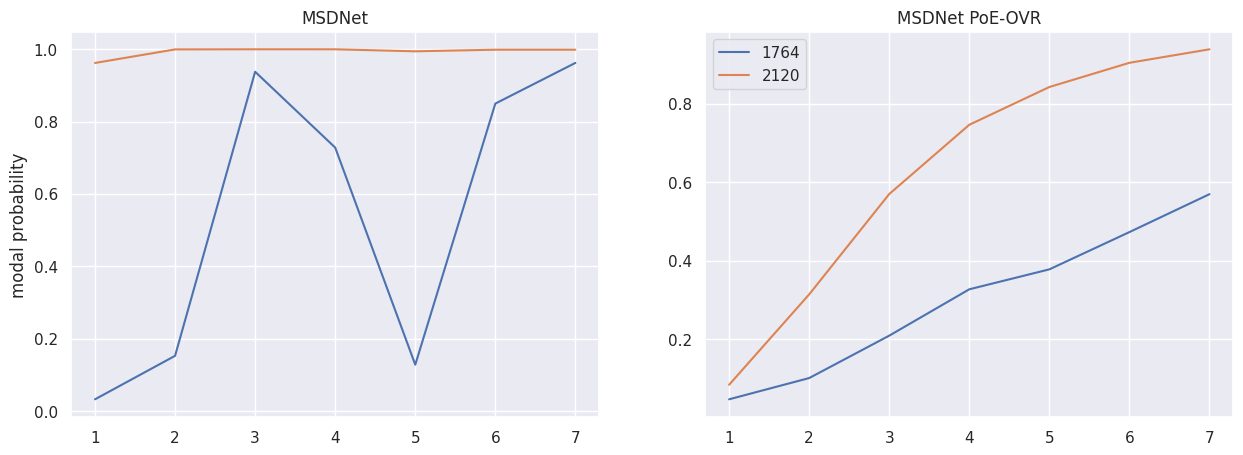

In [101]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# samples = [7762, 2365, 1764, 2767, 2120, 4175, 1596, 4439, 7428, 5743]
samples = [1764, 2120]
for i in samples:
    # probs_i = _probs[:, i, _preds[i]].cpu()
    # probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
    probs_i = _probs[:, i, targets[i]].cpu()
    probs_i_baseline = probs[:, i, targets[i]].cpu()
    ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
    ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
# plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
plt.legend()
ax[0].set_title('MSDNet')
ax[1].set_title('MSDNet PoE-OVR')
ax[0].set_ylabel('modal probability')
plt.show()

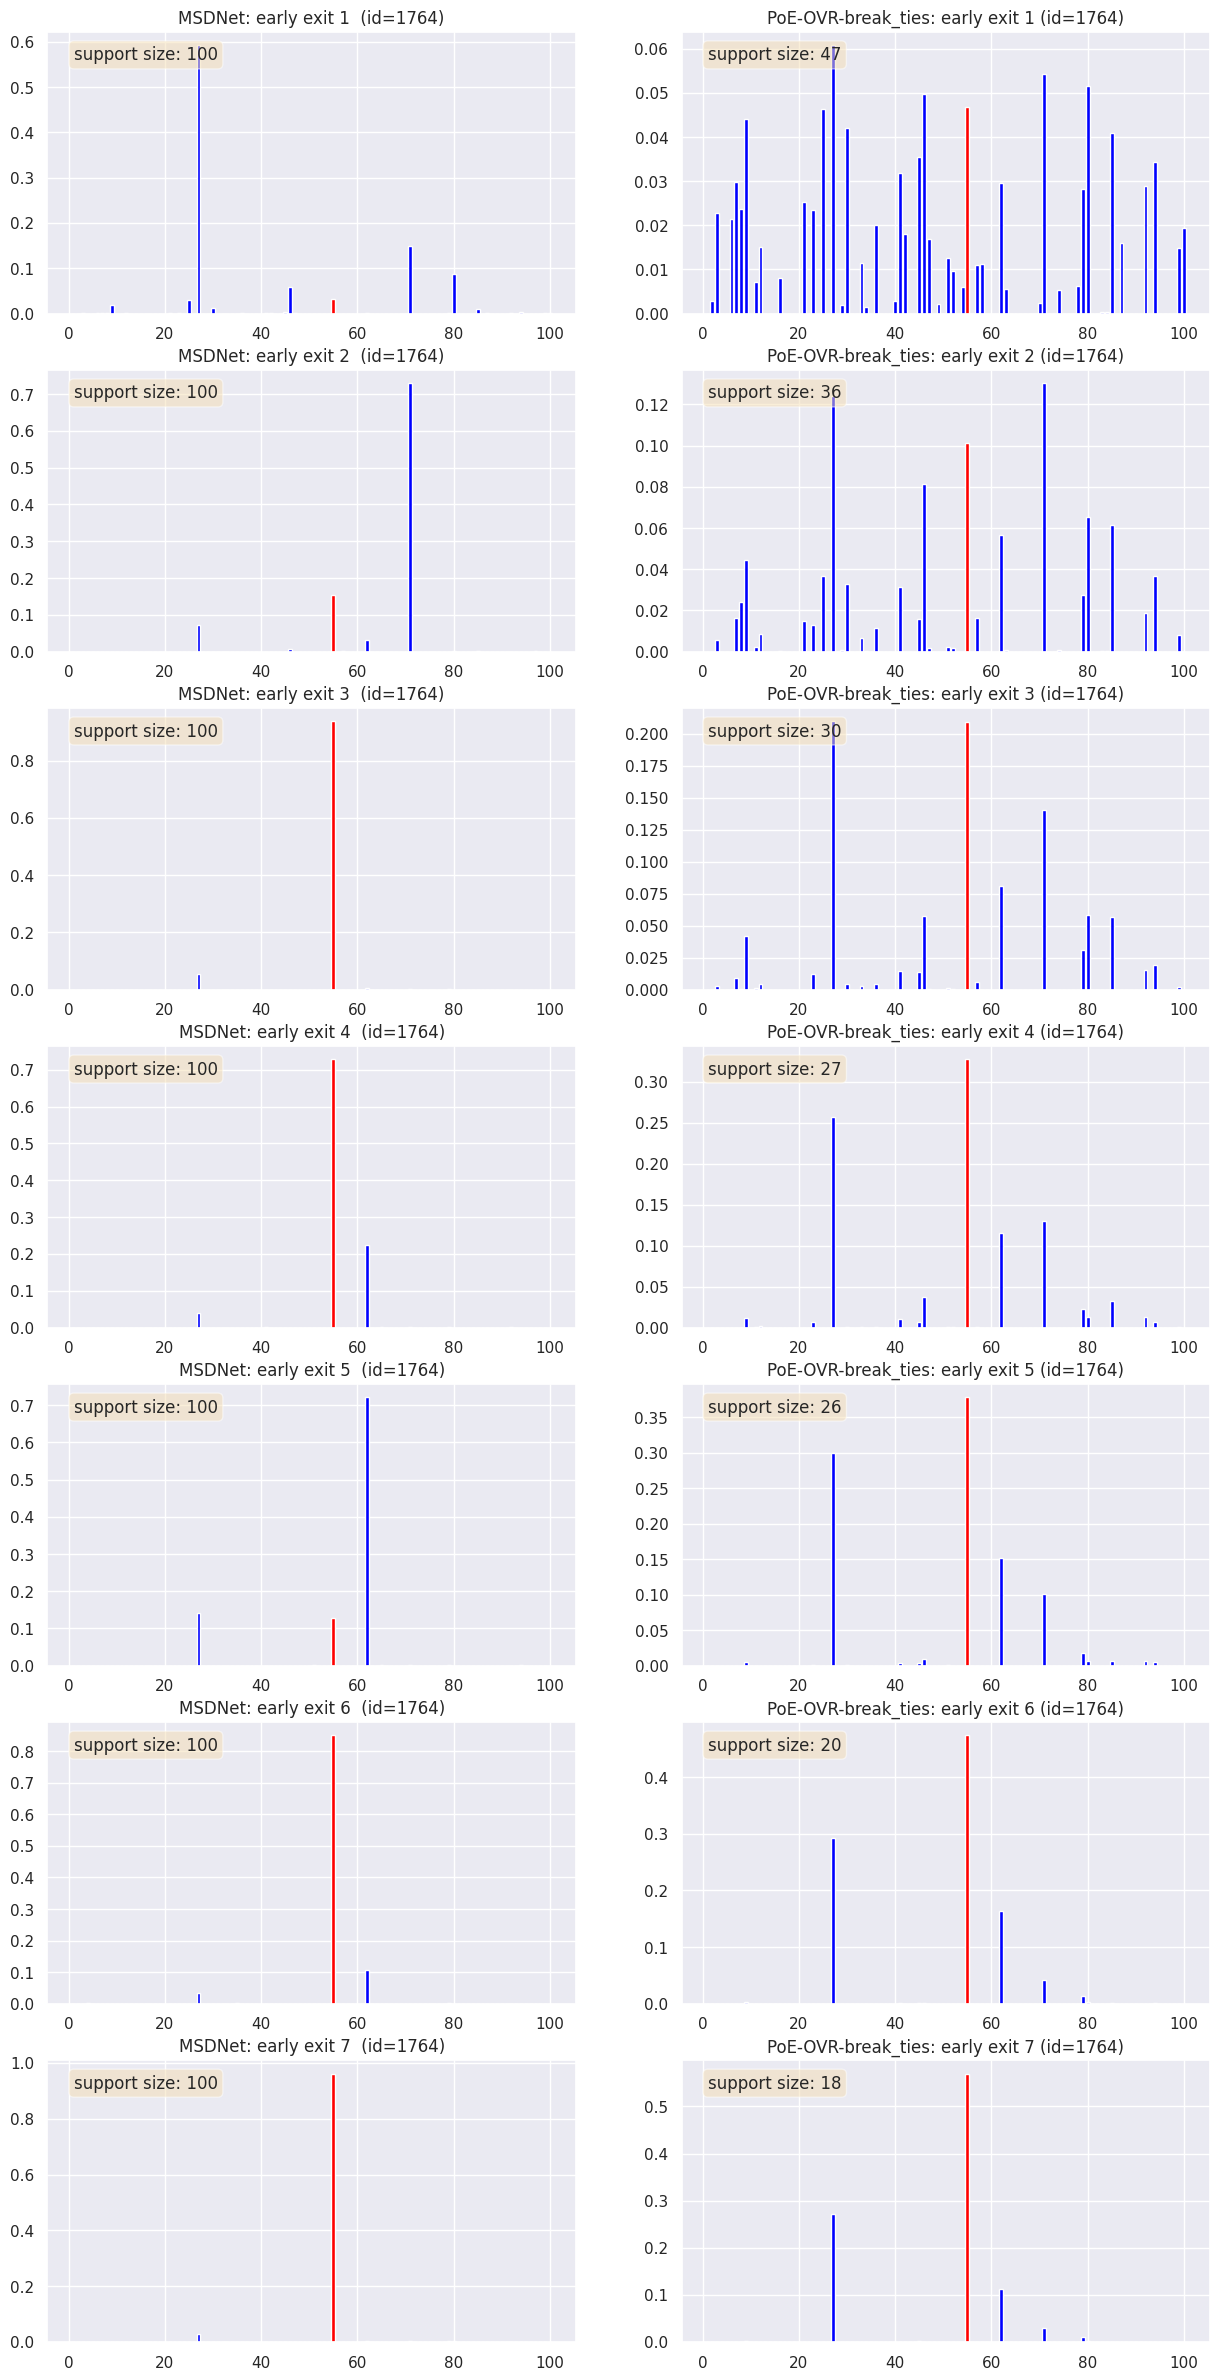

In [102]:
i = 1764
fig, ax = plt.subplots(L, 2, figsize=(15, 30))
for l in range(L):
    # colors = ["blue" if j != preds[L - 1][i] else "red" for j in range(ARGS.num_classes)]
    # _colors = ["blue" if j != _preds[i] else "red" for j in range(ARGS.num_classes)]
    colors = ["blue" if j != targets[i] else "red" for j in range(ARGS.num_classes)]
    _colors = ["blue" if j != targets[i] else "red" for j in range(ARGS.num_classes)]
    ax[l, 0].bar(np.arange(1, ARGS.num_classes + 1, 1), probs[l, i, :].numpy(), color=colors)
    ax[l, 1].bar(np.arange(1, ARGS.num_classes + 1, 1), _probs[l, i, :].numpy(), color=colors)
    ax[l, 0].set_title(f'MSDNet: early exit {l + 1}  (id={i})')
    ax[l, 1].set_title(f'PoE-OVR-break_ties: early exit {l + 1} (id={i})')
    ax[l, 0].text(0.05, 0.95, f'support size: {(probs[l, i, :].numpy() > 0).sum()}', transform=ax[l, 0].transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax[l, 1].text(0.05, 0.95, f'support size: {(_probs[l, i, :].numpy() > 0).sum()}', transform=ax[l, 1].transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# plt.savefig(f'predictive_distributions_{i}.jpg')
plt.show()

In [103]:
probs_poe_ovr_break_ties_thres_4 = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=4.))

In [104]:
entropy_baseline = scipy.stats.entropy(probs.numpy(), axis=2)
entropy_poe_ovr_break_ties = scipy.stats.entropy(probs_poe_ovr_break_ties.numpy(), axis=2)
entropy_poe_ovr_break_ties_thres_4 = scipy.stats.entropy(probs_poe_ovr_break_ties_thres_4.numpy(), axis=2)

In [127]:
l, i = 6, 1000
scipy.stats.entropy(probs_poe_ovr_break_ties[l, i, :]), scipy.stats.entropy(probs_poe_ovr_break_ties[l, i, probs_poe_ovr_break_ties[l, i, :] > 0])

(1.430753, 1.4307531)

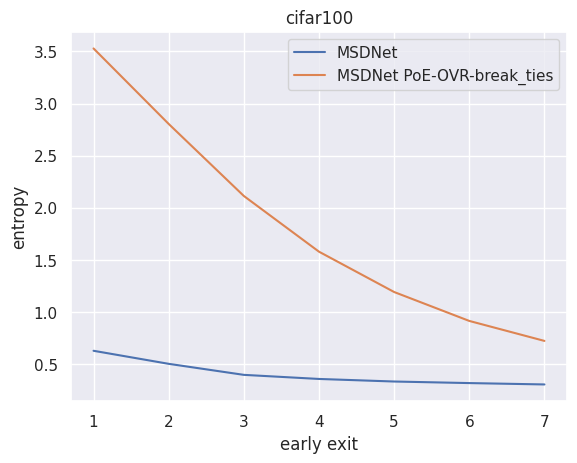

In [106]:
plt.plot(list(range(1, L + 1)), entropy_baseline.mean(axis=1), label='MSDNet')
plt.plot(list(range(1, L + 1)), entropy_poe_ovr_break_ties.mean(axis=1), label='MSDNet PoE-OVR-break_ties')
plt.legend()
plt.title(f'{ARGS.data}')
plt.ylabel('entropy')
plt.xlabel('early exit')
plt.show()

## 9 Generalized PoE

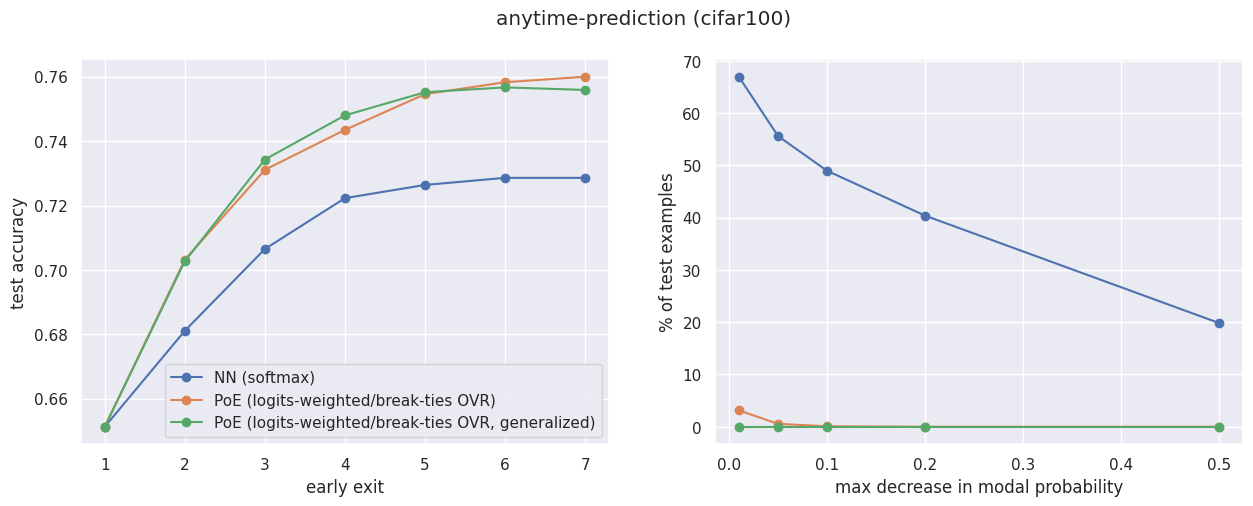

In [107]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='NN (softmax)', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='PoE (logits-weighted/break-ties OVR)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='PoE (logits-weighted/break-ties OVR, generalized)', marker='o')
ax[0].legend()
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (logits-weighted/break-ties OVR)'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'PoE (logits-weighted/break-ties OVR, generalized)'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

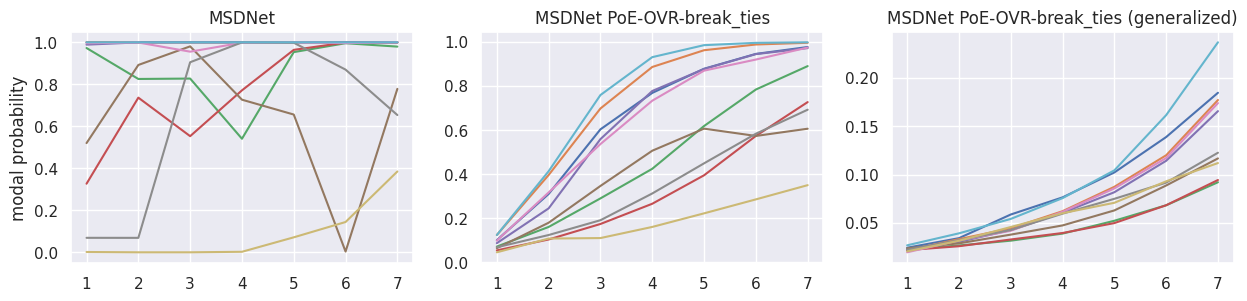

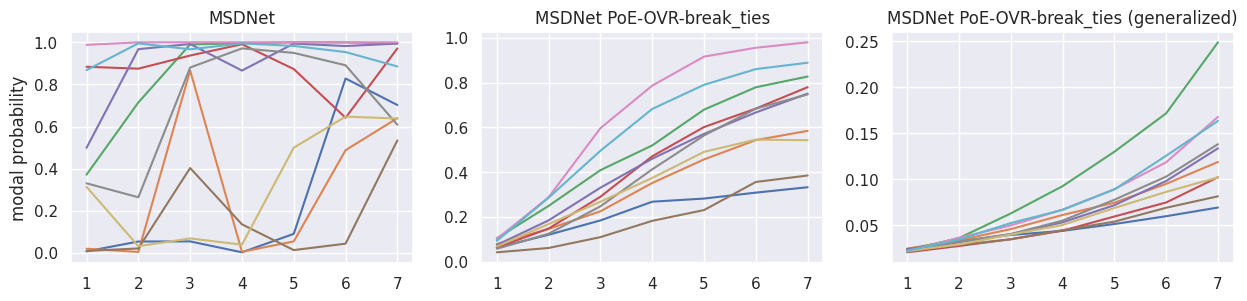

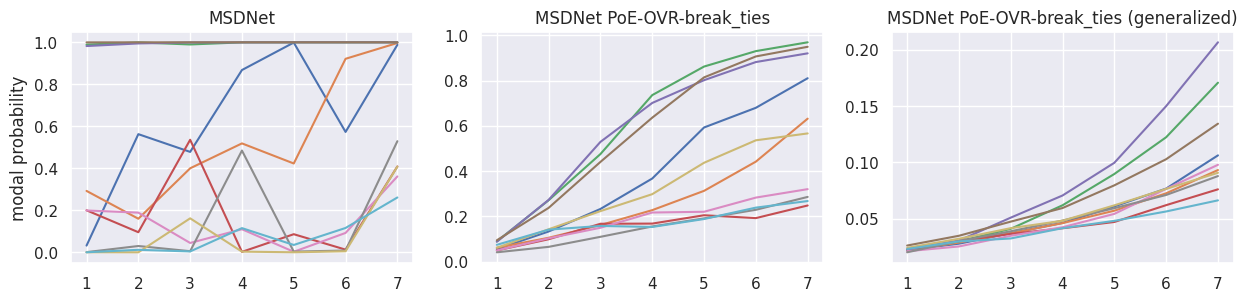

In [108]:
for _ in range(3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    samples = random.sample(range(N), 10)
    # print(samples)
    for i in samples:
        probs_i = probs_poe_ovr_break_ties[:, i, preds_poe_ovr_break_ties[L - 1][i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        # probs_i_ = probs_poe_ovr_break_ties_softmax_first[:, i, preds_poe_ovr_break_ties_softmax_first[L - 1][i]].cpu()
        probs_i_ = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
        ax[2].plot(list(range(1, len(probs_i_) + 1)), probs_i_, label=f'{i}');
        ax[0].set_xticks(range(1, len(probs_i_baseline) + 1))
        ax[1].set_xticks(range(1, len(probs_i_baseline) + 1))
        ax[2].set_xticks(range(1, len(probs_i_baseline) + 1))
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('MSDNet')
    ax[1].set_title('MSDNet PoE-OVR-break_ties')
    ax[2].set_title('MSDNet PoE-OVR-break_ties (generalized)')
    ax[0].set_ylabel('modal probability')
    plt.show()

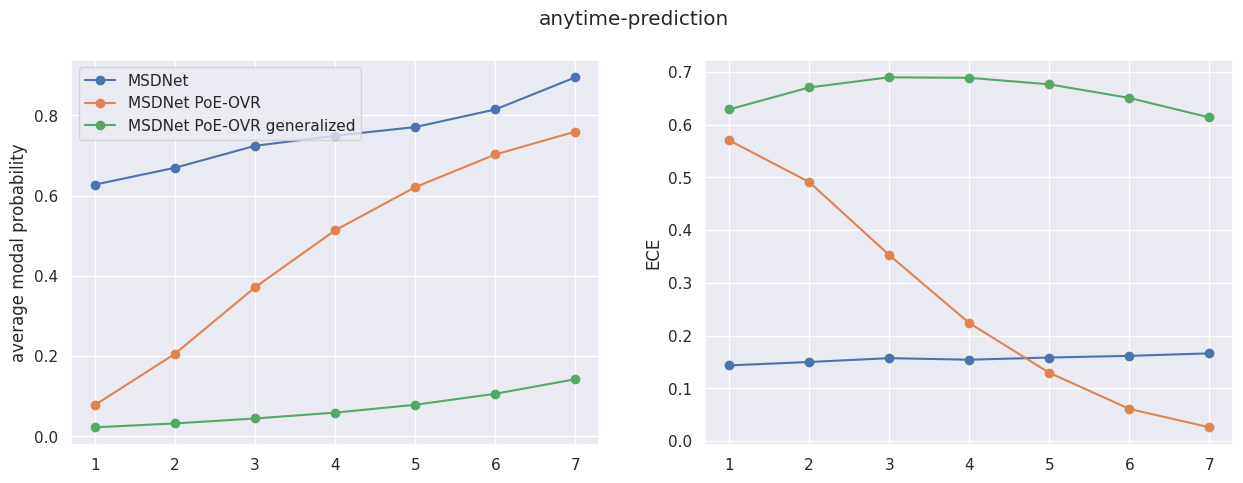

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'MSDNet'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'MSDNet PoE-OVR'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'MSDNet PoE-OVR generalized'),
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L)
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, modal_probs.numpy(), marker='o', label=label)
    ax[1].plot(early_exits, ece, marker='o', label=label)
ax[0].legend()
ax[0].set_ylabel('average modal probability')
ax[1].set_ylabel('ECE')


plt.suptitle('anytime-prediction')
plt.show()

#### 9.1 overflow for unnormalized weights

In [110]:
weights = np.arange(1, L + 1, 1, dtype=float)
test_arr = logits.numpy().copy()
test_arr[test_arr < 0.] = 0.
for l in range(L):
    test_arr[l, :, :] = test_arr[l, :, :] ** weights[l]
test_arr = np.cumprod(test_arr, axis=0)

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


In [111]:
(test_arr.max(axis=2) == np.inf).sum(axis=1)

array([   0,    0,    0,    0,    0,    0, 3166])

In [112]:
# def f_probs_ovr_poe_logits_weighted_generalized_num_stable(logits, threshold=0., weights=None):
#     test_arr = logits.numpy().copy()
#     test_arr[test_arr < 0.] = 0.
#     test_arr = np.log(test_arr + 1)
#     test_arr[test_arr == -np.inf] = 0.
#     for l in range(L):
#         test_arr[l, :, :] = test_arr[l, :, :] * weights[l]
#     test_arr = np.cumsum(test_arr, axis=0)
#     test_arr = (test_arr / np.repeat(test_arr.sum(axis=2)[:, :, np.newaxis], ARGS.num_classes, axis=2))
#     return test_arr

In [113]:
# probs_poe_ovr_break_ties_generalized_num_stable = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.arange(1, L + 1, 1, dtype=float)))
# # probs_poe_ovr_break_ties_generalized_num_stable = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized_num_stable(logits, weights=np.arange(1, L + 1, 1, dtype=float) / (L * (L + 1) / 2)))
# preds_poe_ovr_break_ties_generalized_num_stable = {i: torch.argmax(probs_poe_ovr_break_ties_generalized_num_stable, dim=2)[i, :] for i in range(L)}
# acc_poe_ovr_break_ties_generalized_num_stable = [(targets == preds_poe_ovr_break_ties_generalized_num_stable[i]).sum() / len(targets) for i in range(L)]

In [114]:
# acc_poe_ovr_break_ties_generalized, modal_probs_decreasing(preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, L)

In [115]:
# acc_poe_ovr_break_ties_generalized_num_stable, modal_probs_decreasing(preds_poe_ovr_break_ties_generalized_num_stable, probs_poe_ovr_break_ties_generalized_num_stable, L)